## Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, FunctionTransformer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults
from pmdarima import auto_arima

In [3]:
def human_format(num):
  """Convert a number to a human readable version, e.g. 10M for 10,000,000."""
  if num == 0:
    return '0'
  letters = ["", "K", "M", "B", "T"]
  scale = math.floor(round(math.log(abs(num), 10)) / 3)
  # Convert to string: truncate to scale, remove trailing zeros and decimal points
  num = float('{:.3g}'.format(num)) / 10**(3*scale)
  num = str(num).rstrip('0').rstrip('.')
  # Append scale letter
  num += letters[scale]
  return num

def mpl_human_format(x, pos):
  if pos is not None:
    return human_format(x)

def make_axes_human_readable(ax, axis="y"):
  if axis.lower() == 'x':
    axisvar = ax.xaxis
  elif axis.lower() == 'y':
    axisvar = ax.yaxis
  else:
    raise("Must specify axis as either 'x' or 'y'")

  axisvar.set_major_formatter(matplotlib.ticker.FuncFormatter(mpl_human_format))
  return ax

## Import and process data

### Preprocess electricity usage clusters

In [5]:
# Load the electricity usage data
NUM_CLUSTERS = 4

cluster_dfs = list()

for i in range(1, NUM_CLUSTERS + 1):
    df = pd.concat([
        pd.read_parquet(f'dataset/cluster_{i}/training.parquet'),
        pd.read_parquet(f'dataset/cluster_{i}/validation.parquet'),
        pd.read_parquet(f'dataset/cluster_{i}/test.parquet'),
    ], axis=1).T.sort_index()
    df.index = pd.to_datetime(df.index)
    df.index.name = 'date'
    cluster_dfs.append(df)

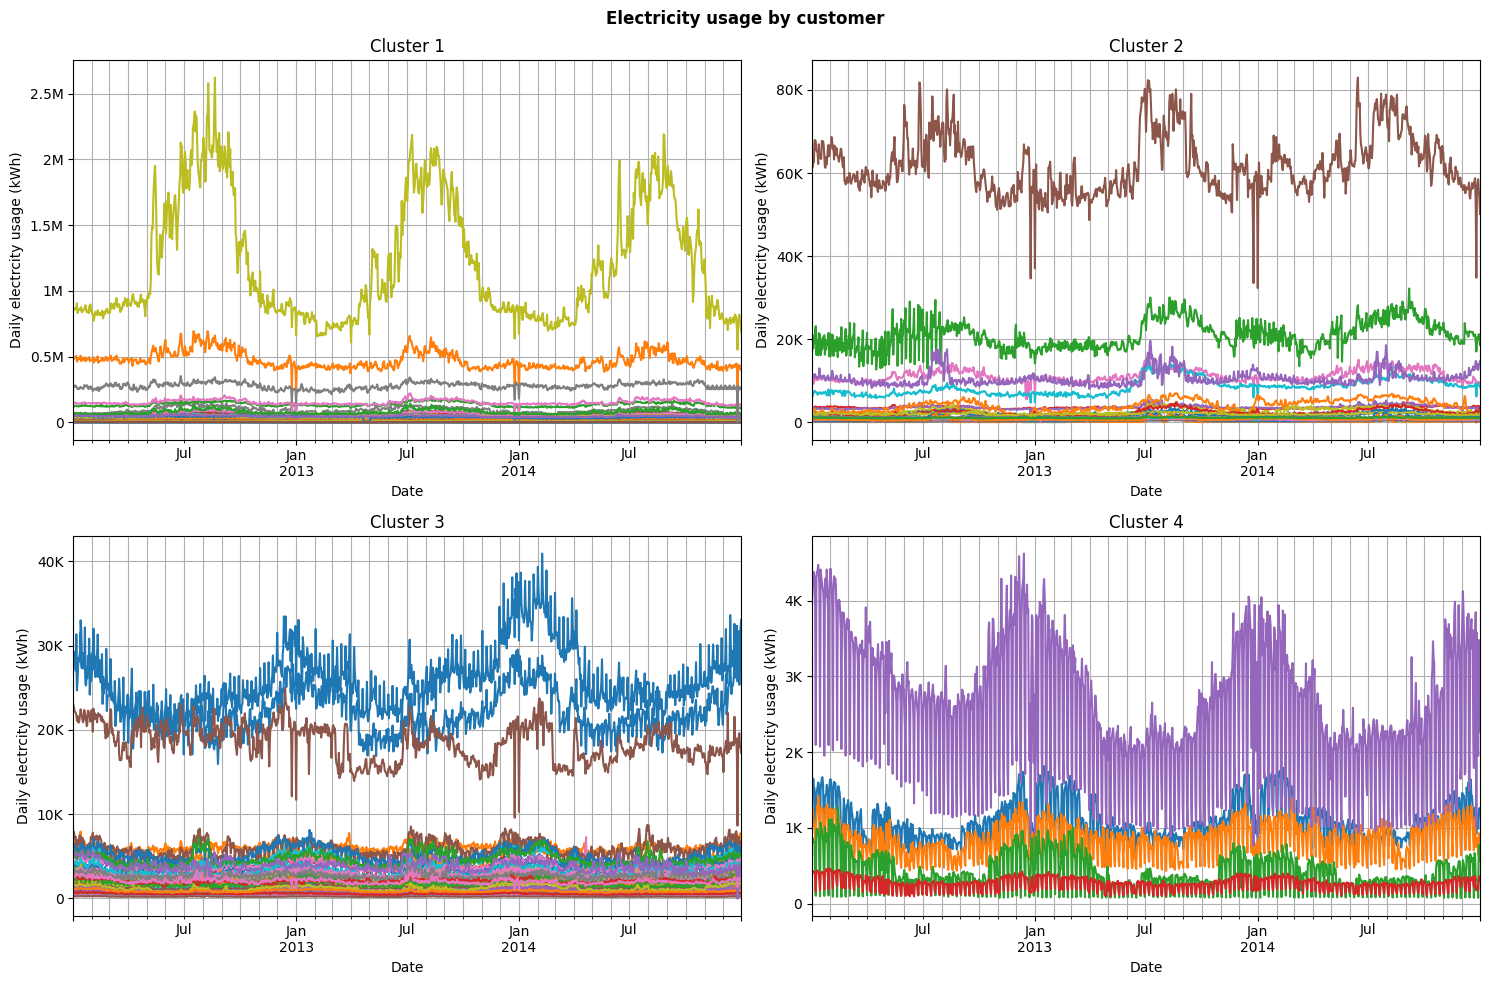

In [4]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

fig.suptitle('Electricity usage by customer', fontweight='bold')

for i, (ax, df) in enumerate(zip(axs.flatten(), cluster_dfs), start=1):
    df.plot(ax=ax)

    make_axes_human_readable(ax)
    ax.set_title(f'Cluster {i}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Daily electrcity usage (kWh)')
    ax.grid(True, which='both')
    ax.legend().remove()

plt.tight_layout()
plt.show()

In [5]:
def plot_scaled_electrcity_usage(scaler, cluster_dfs):
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
    
    fig.suptitle(f'({scaler.__class__.__name__}) Electricity usage by customer', fontweight='bold')
    for i, (ax, df) in enumerate(zip(axs.flatten(), cluster_dfs), start=1):
        scaled_df = pd.DataFrame(
            scaler.fit_transform(df),
            columns=df.columns,
            index=df.index
        )
        scaled_df.plot(ax=ax)
        scaled_df.mean(axis=1).plot(ax=ax, color='black')
    
        ax.set_title(f'Cluster {i}')
        ax.set_xlabel('Date')
        ax.set_ylabel('Daily electrcity usage')
        ax.grid(True, which='both')
        ax.legend().remove()

    plt.tight_layout()
    plt.show()

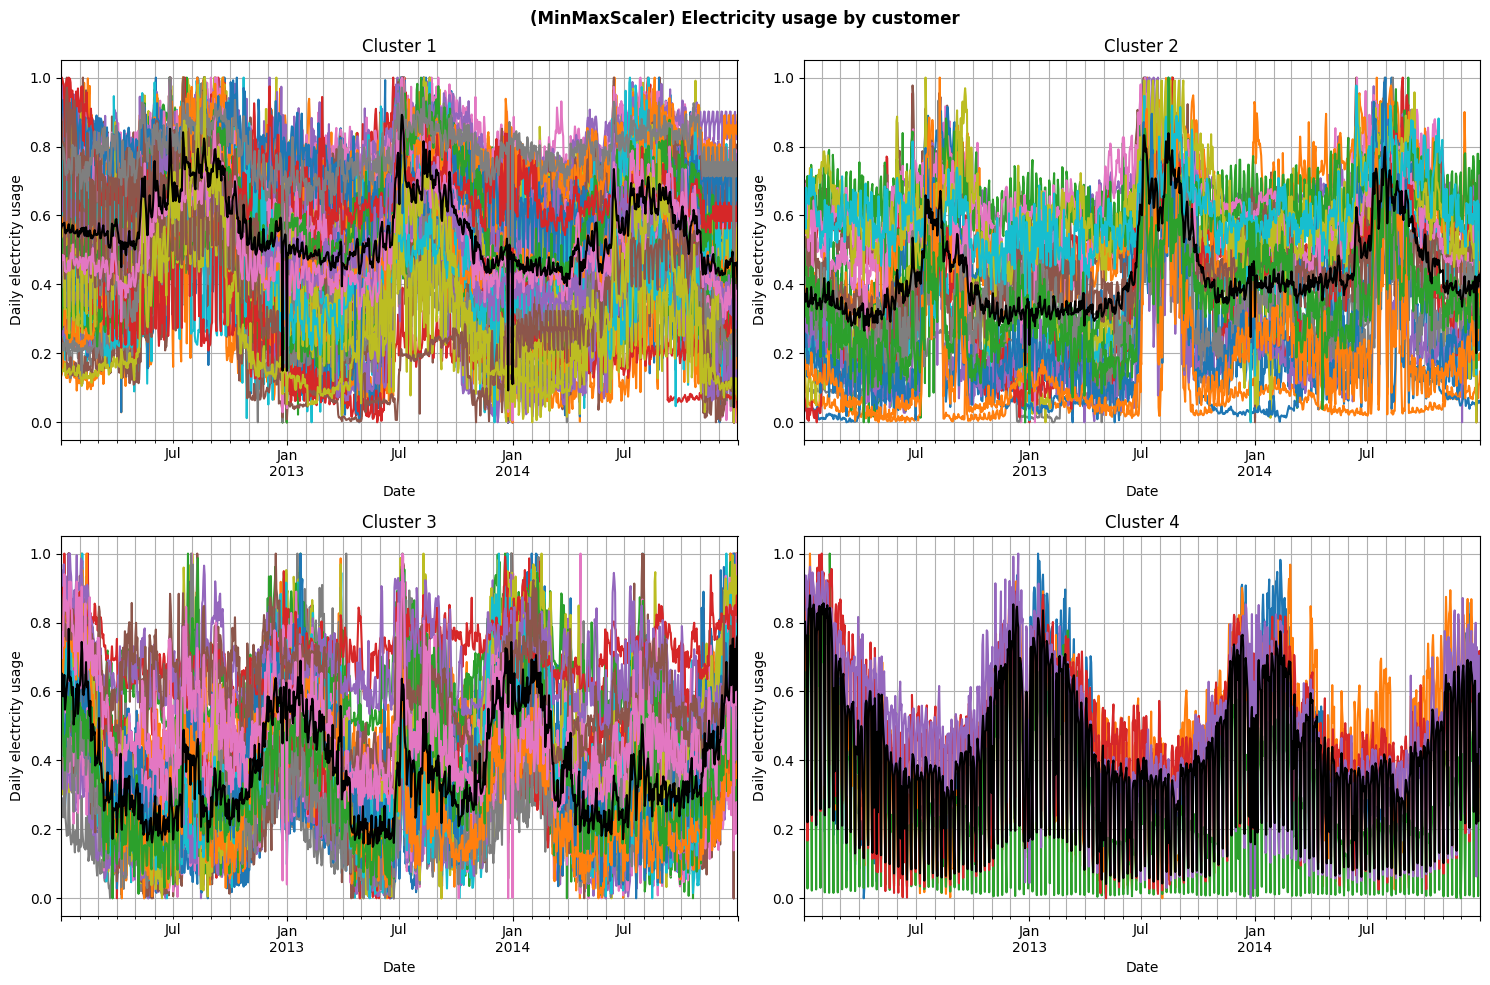

In [7]:
scaler = MinMaxScaler()
plot_scaled_electrcity_usage(scaler, cluster_dfs)

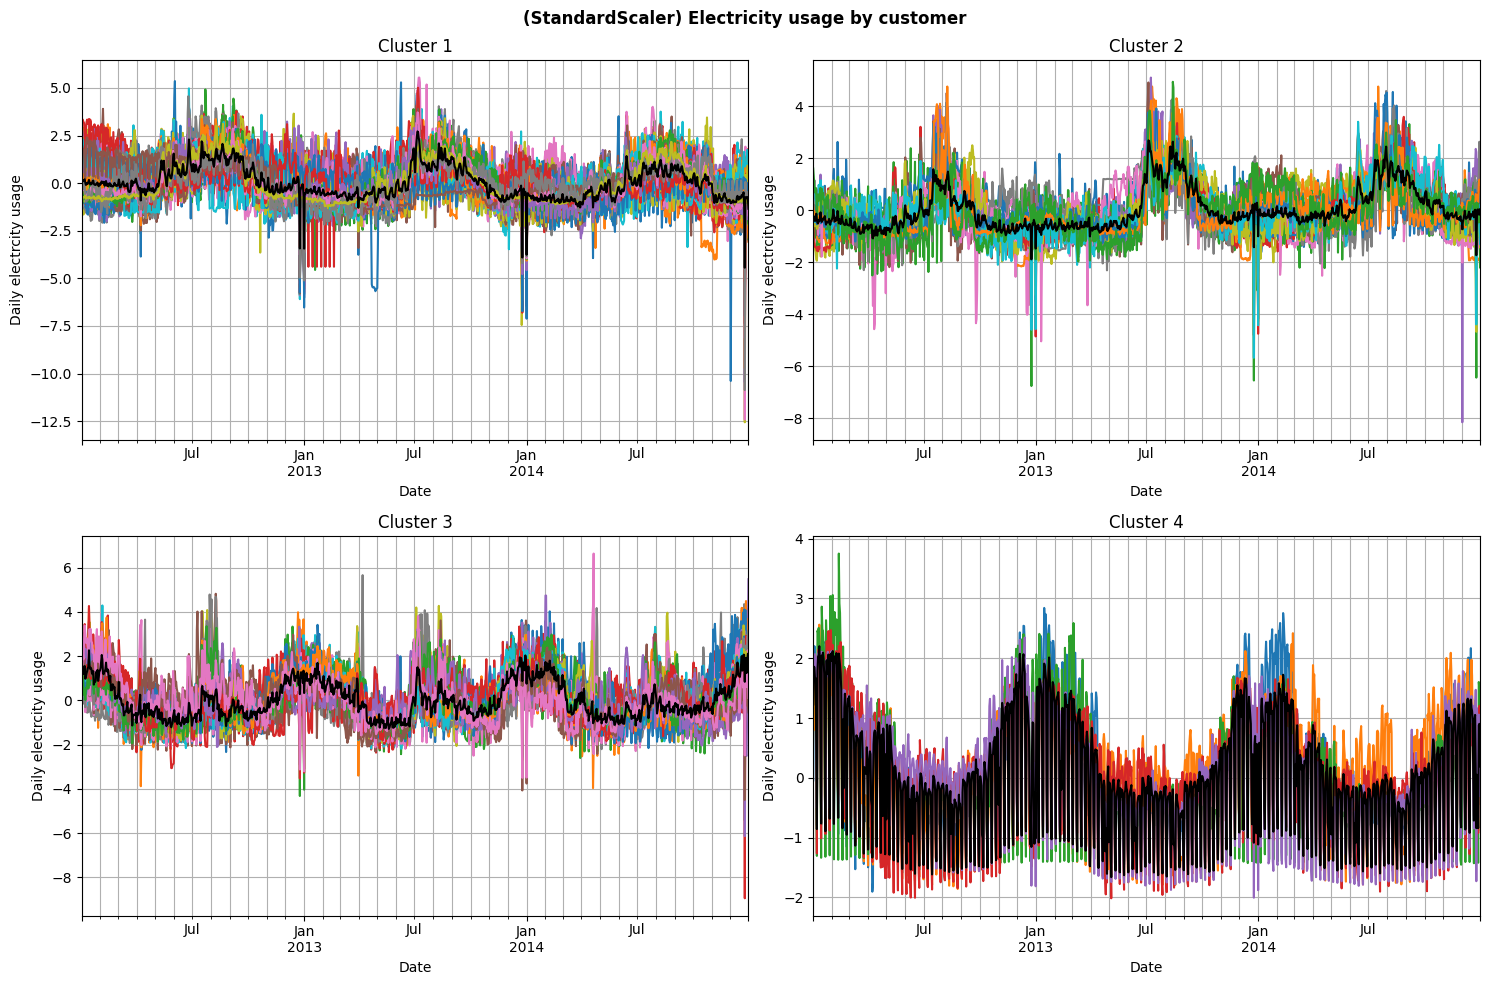

In [8]:
scaler = StandardScaler()
plot_scaled_electrcity_usage(scaler, cluster_dfs)

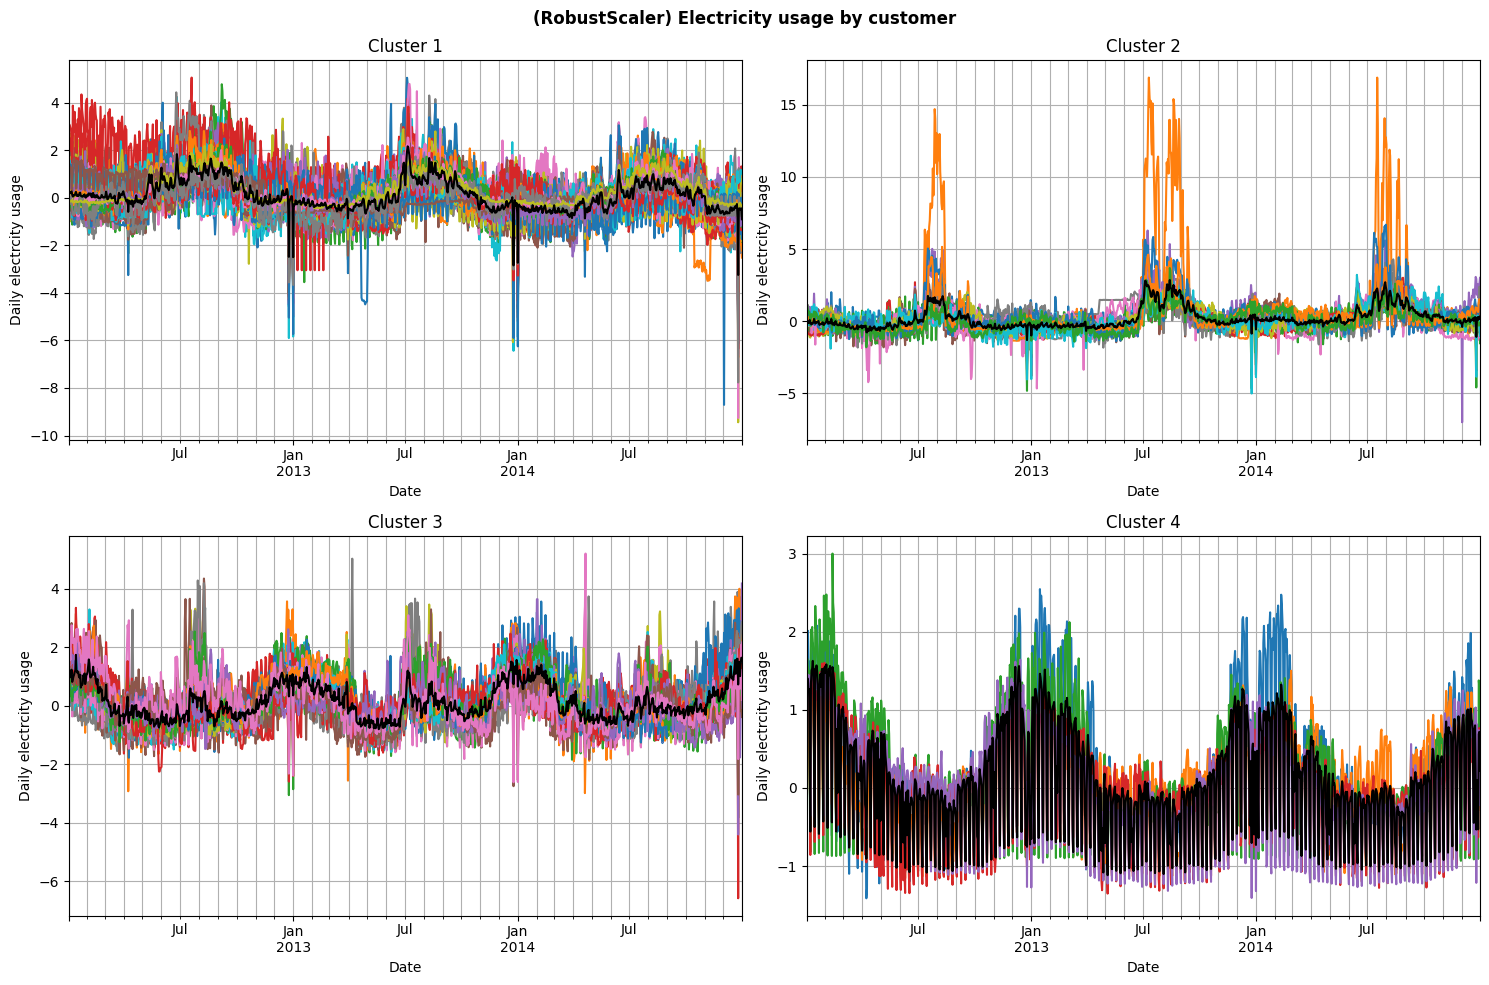

In [9]:
scaler = RobustScaler()
plot_scaled_electrcity_usage(scaler, cluster_dfs)

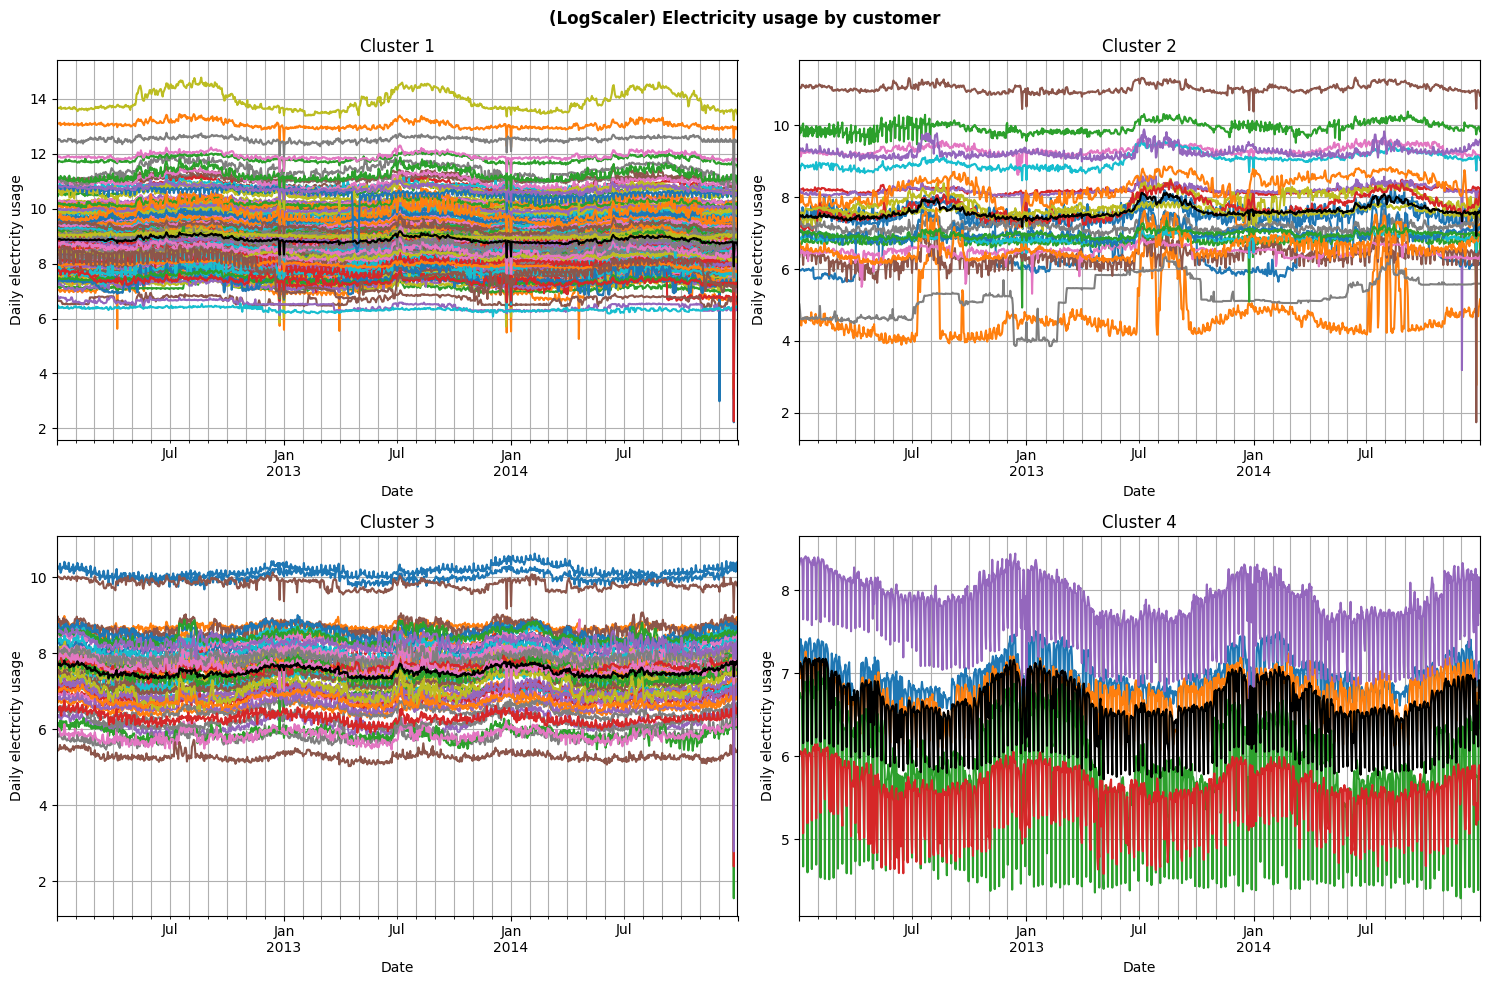

In [10]:
scaler = FunctionTransformer(np.log1p, validate=True)
scaler.__class__.__name__ = 'LogScaler'

plot_scaled_electrcity_usage(scaler, cluster_dfs)

### Import the explanatory variables

In [7]:
explanatory_variables_df = pd.read_parquet('dataset/combined_explanatory_variables/explanatory_variables.parquet')
explanatory_variables_df.index = pd.to_datetime(explanatory_variables_df.index)
explanatory_variables_df = explanatory_variables_df.sort_index().asfreq('D')
explanatory_variables_df.head()

heating_degree_days  cooling_degree_days  precip  precipprob  \
date                                                                       
2012-01-01             6.578559                  0.0   0.000         0.0   
2012-01-02             6.659918                  0.0   0.111         1.0   
2012-01-03             7.977833                  0.0   0.000         0.0   
2012-01-04             6.335269                  0.0   0.000         0.0   
2012-01-05             7.437771                  0.0   0.000         0.0   

            is_holiday  sunlight_length_hours  is_weekend  
date                                                       
2012-01-01           0                   10.0           1  
2012-01-02           0                   10.0           0  
2012-01-03           0                   10.0           0  
2012-01-04           0                   10.0           0  
2012-01-05           0                   10.0           0

### Combine the electricity usage and explanatory variables

In [8]:
melted_dfs = list()
for i, df in enumerate(cluster_dfs, start=1):
    melted_df = pd.melt(df.reset_index(), id_vars=['date'], var_name='customer', value_name='electricity_usage')
    melted_df['cluster'] = i
    melted_dfs.append(melted_df)

combined_melted_df = pd.concat(melted_dfs, axis=0)
customer_level_dataset_df = pd.merge(combined_melted_df, explanatory_variables_df, on='date', how='inner')
customer_level_dataset_df = customer_level_dataset_df.set_index(['date', 'customer', 'cluster'])
customer_level_dataset_df.head()

electricity_usage  heating_degree_days  \
date       customer cluster                                           
2012-01-02 MT_091   1              3141.260841             6.659918   
2012-01-03 MT_091   1              3424.616411             7.977833   
2012-01-04 MT_091   1              3465.810540             6.335269   
2012-01-05 MT_091   1              3578.052035             7.437771   
2012-01-06 MT_091   1              3697.965310             8.166583   

                             cooling_degree_days  precip  precipprob  \
date       customer cluster                                            
2012-01-02 MT_091   1                        0.0   0.111         1.0   
2012-01-03 MT_091   1                        0.0   0.000         0.0   
2012-01-04 MT_091   1                        0.0   0.000         0.0   
2012-01-05 MT_091   1                        0.0   0.000         0.0   
2012-01-06 MT_091   1                        0.0   0.000         0.0   

                             is_holiday  sunlight_length_hours  is_weekend  
date       customer cluster                                                 
2012-01-02 MT_091   1                 0                   10.0           0  
2012-01-03 MT_091   1                 0                   10.0           0  
2012-01-04 MT_091   1                 0                   10.0           0  
2012-01-05 MT_091   1                 0                   10.0           0  
2012-01-06 MT_091   1                 0                   10.0           0

## Explore SARIMA Hyperparameters

In [9]:
scaler = StandardScaler()

cutoff_date = pd.to_datetime('2014-01-01')

boxcox_dfs = list()
scaled_dfs = list()
mean_series = list()
mean_train_series = list()
mean_test_series = list()

for df in cluster_dfs:
    boxcox_df = df.apply(lambda column: boxcox(column)[0])
    scaled_df = pd.DataFrame(
        scaler.fit_transform(boxcox_df),
        index=boxcox_df.index,
        columns=boxcox_df.columns
    )
    mean = scaled_df.mean(axis=1)
    mean_train = mean[mean.index < cutoff_date]
    mean_test = mean[mean.index >= cutoff_date]
    boxcox_dfs.append(boxcox_df)
    scaled_dfs.append(scaled_df)
    mean_series.append(mean)
    mean_train_series.append(mean_train)
    mean_test_series.append(mean_test)

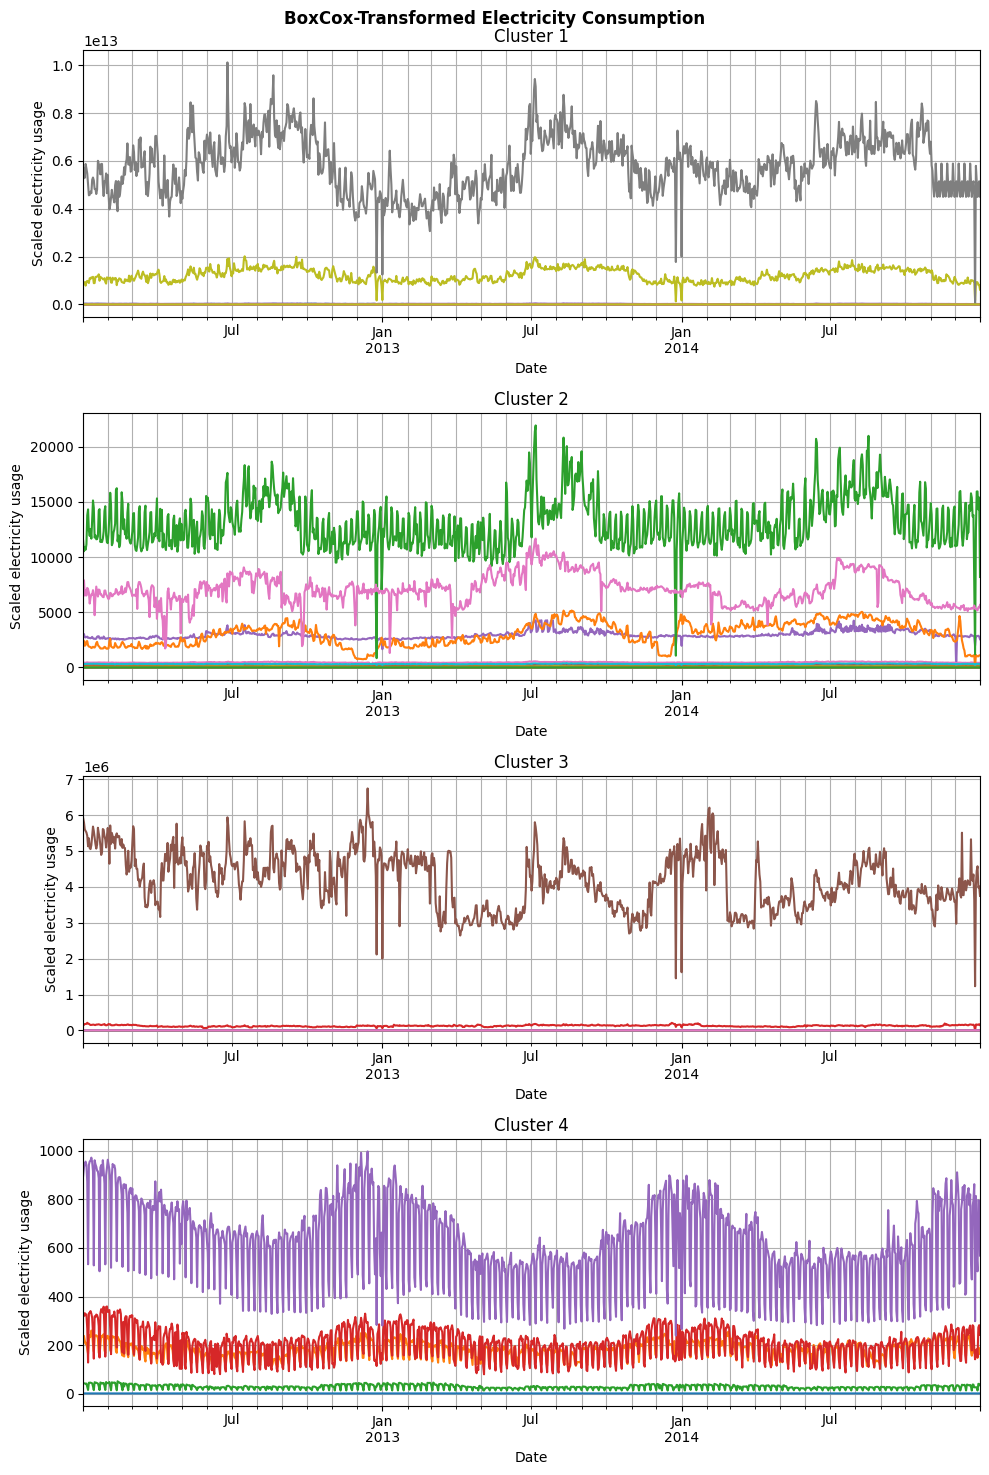

In [104]:
fig, axs = plt.subplots(nrows=len(boxcox_dfs), ncols=1, figsize=(10,15))

fig.suptitle('BoxCox-Transformed Electricity Consumption', fontweight='bold')

for i, (ax, df) in enumerate(zip(axs, boxcox_dfs), start=1):
    df.plot(ax=ax)

    ax.set_title(f'Cluster {i}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Scaled electricity usage')
    ax.legend().remove()
    ax.grid(True, which='both')

plt.tight_layout()
plt.show()

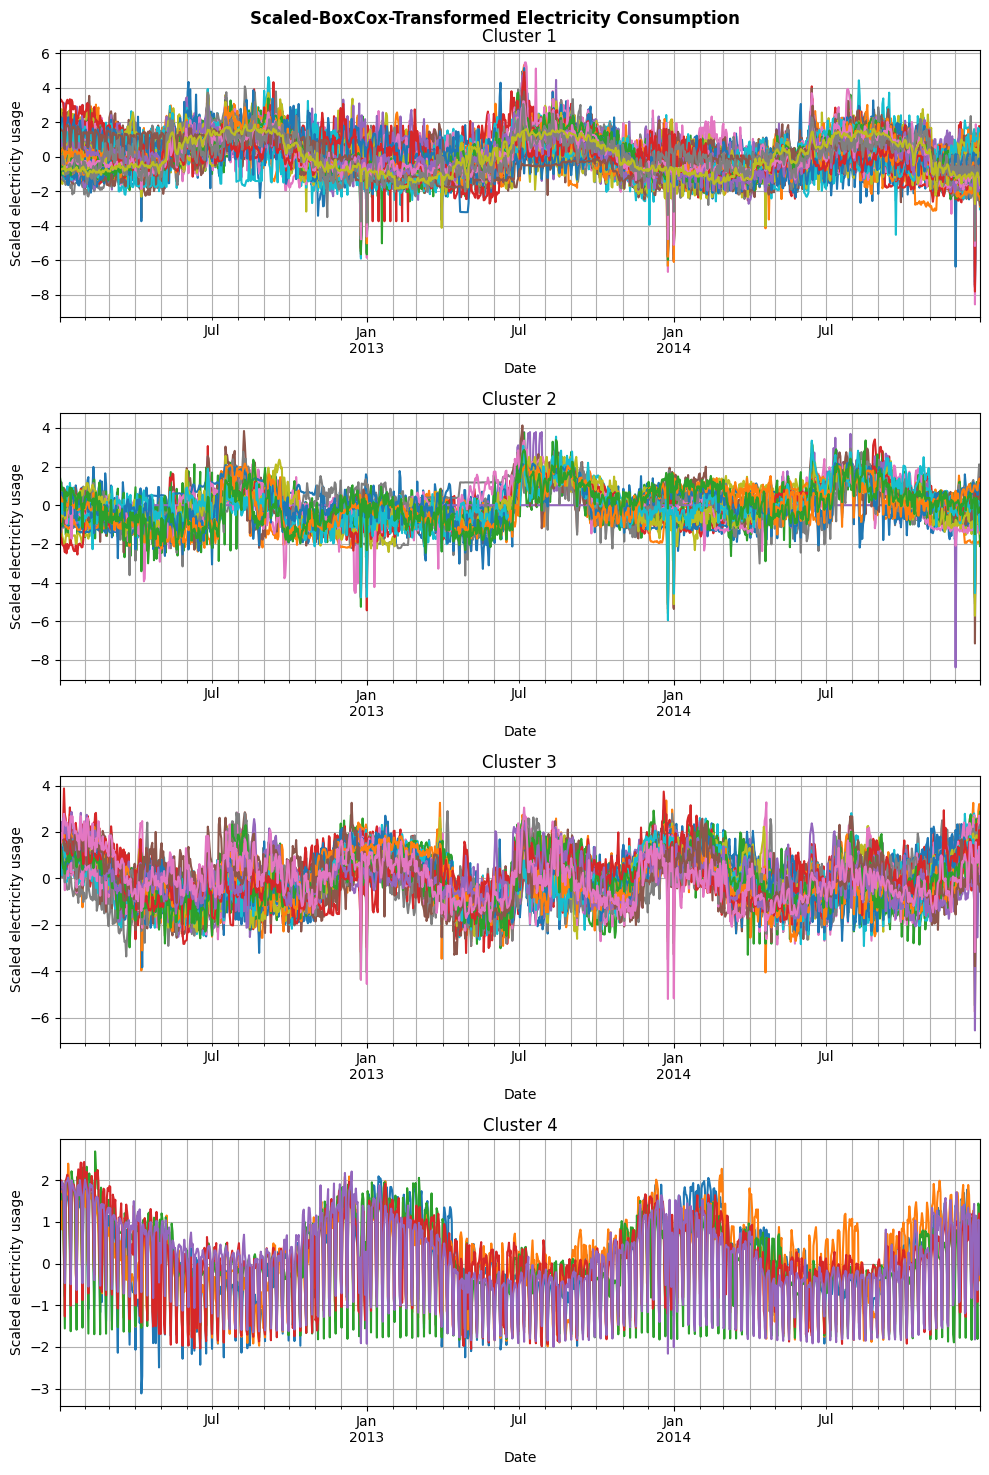

In [105]:
fig, axs = plt.subplots(nrows=len(boxcox_dfs), ncols=1, figsize=(10,15))

fig.suptitle('Scaled-BoxCox-Transformed Electricity Consumption', fontweight='bold')

for i, (ax, df) in enumerate(zip(axs, scaled_dfs), start=1):
    df.plot(ax=ax)

    ax.set_title(f'Cluster {i}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Scaled electricity usage')
    ax.legend().remove()
    ax.grid(True, which='both')

plt.tight_layout()
plt.show()

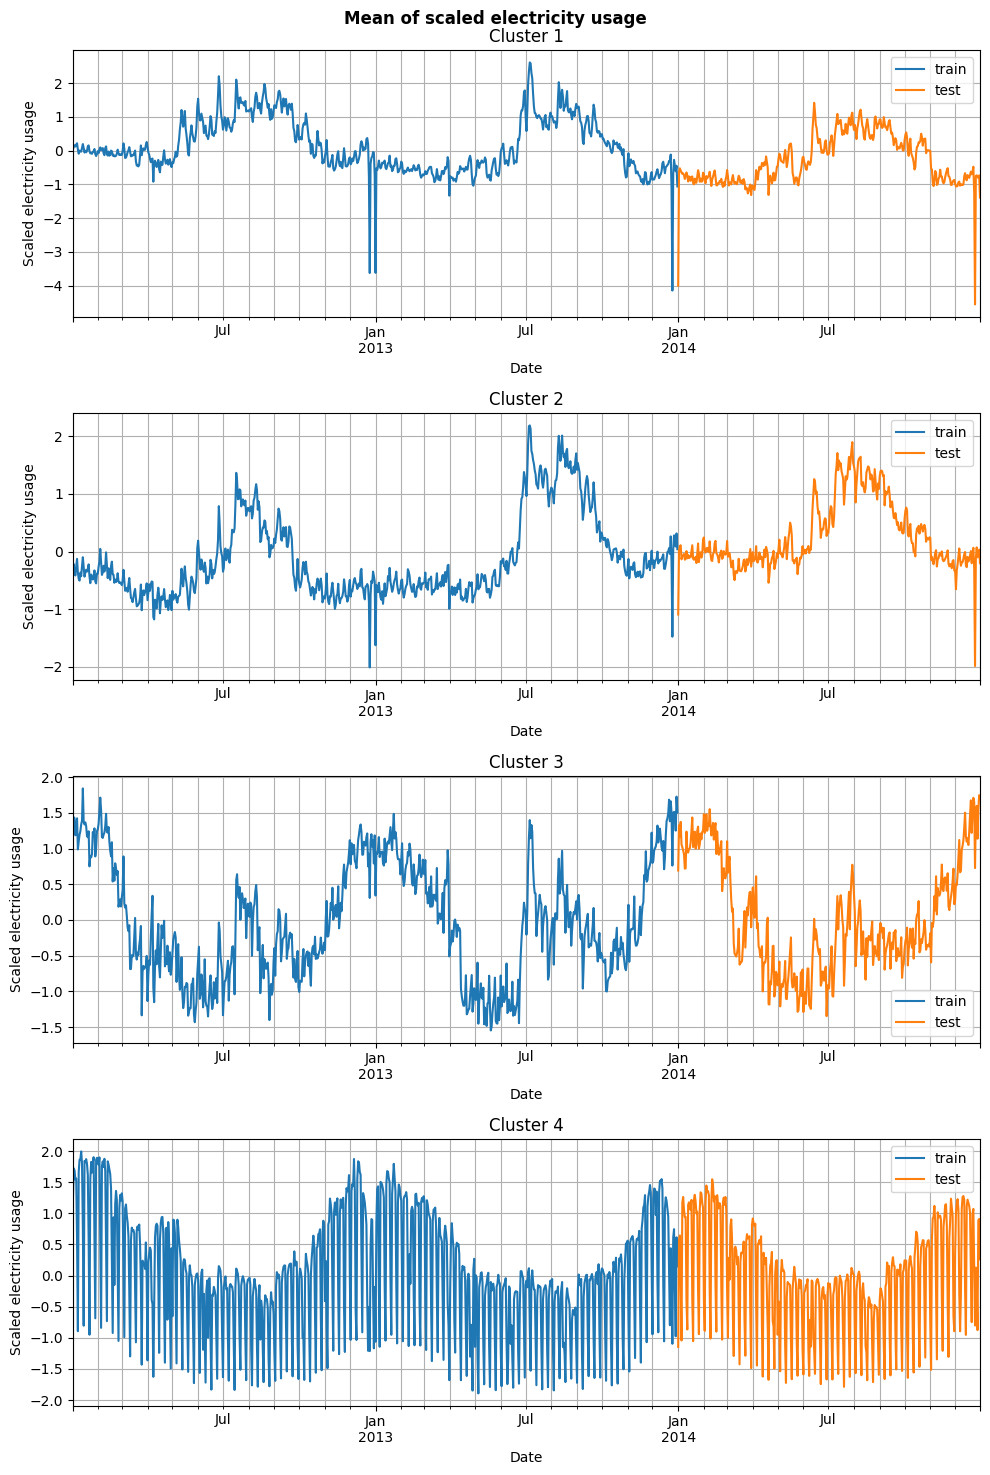

In [106]:
fig, axs = plt.subplots(nrows=len(mean_of_scaled_cluster_dfs), ncols=1, figsize=(10,15))

fig.suptitle('Mean of scaled electricity usage', fontweight='bold')

for i, (ax, train_df, test_df) in enumerate(zip(axs, mean_train_series, mean_test_series), start=1):
    train_df.plot(ax=ax, color='tab:blue', label='train')
    test_df.plot(ax=ax, color='tab:orange', label='test')

    ax.set_title(f'Cluster {i}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Scaled electricity usage')
    ax.legend()
    ax.grid(True, which='both')

plt.tight_layout()
plt.show()

In [107]:
def show_adf_analysis(dfs, window=0):
    print('Differencing:', window)
    for i, df in enumerate(dfs, start=1):
        if window > 0:
            result = adfuller(df.diff(window).dropna())
        else:
            result = adfuller(df)
        print(f'Cluster {i}')
        print('\tADF Statistic:', result[0].round(2))
        print('\tp-value:', result[1].round(3))

In [108]:
show_adf_analysis(mean_of_scaled_cluster_dfs_train)

Differencing: 0
Cluster 1
	ADF Statistic: -2.12
	p-value: 0.238
Cluster 2
	ADF Statistic: -2.28
	p-value: 0.179
Cluster 3
	ADF Statistic: -2.66
	p-value: 0.082
Cluster 4
	ADF Statistic: -2.29
	p-value: 0.174


In [109]:
show_adf_analysis(mean_of_scaled_cluster_dfs_train, 1)

Differencing: 1
Cluster 1
	ADF Statistic: -12.82
	p-value: 0.0
Cluster 2
	ADF Statistic: -5.81
	p-value: 0.0
Cluster 3
	ADF Statistic: -5.18
	p-value: 0.0
Cluster 4
	ADF Statistic: -6.98
	p-value: 0.0


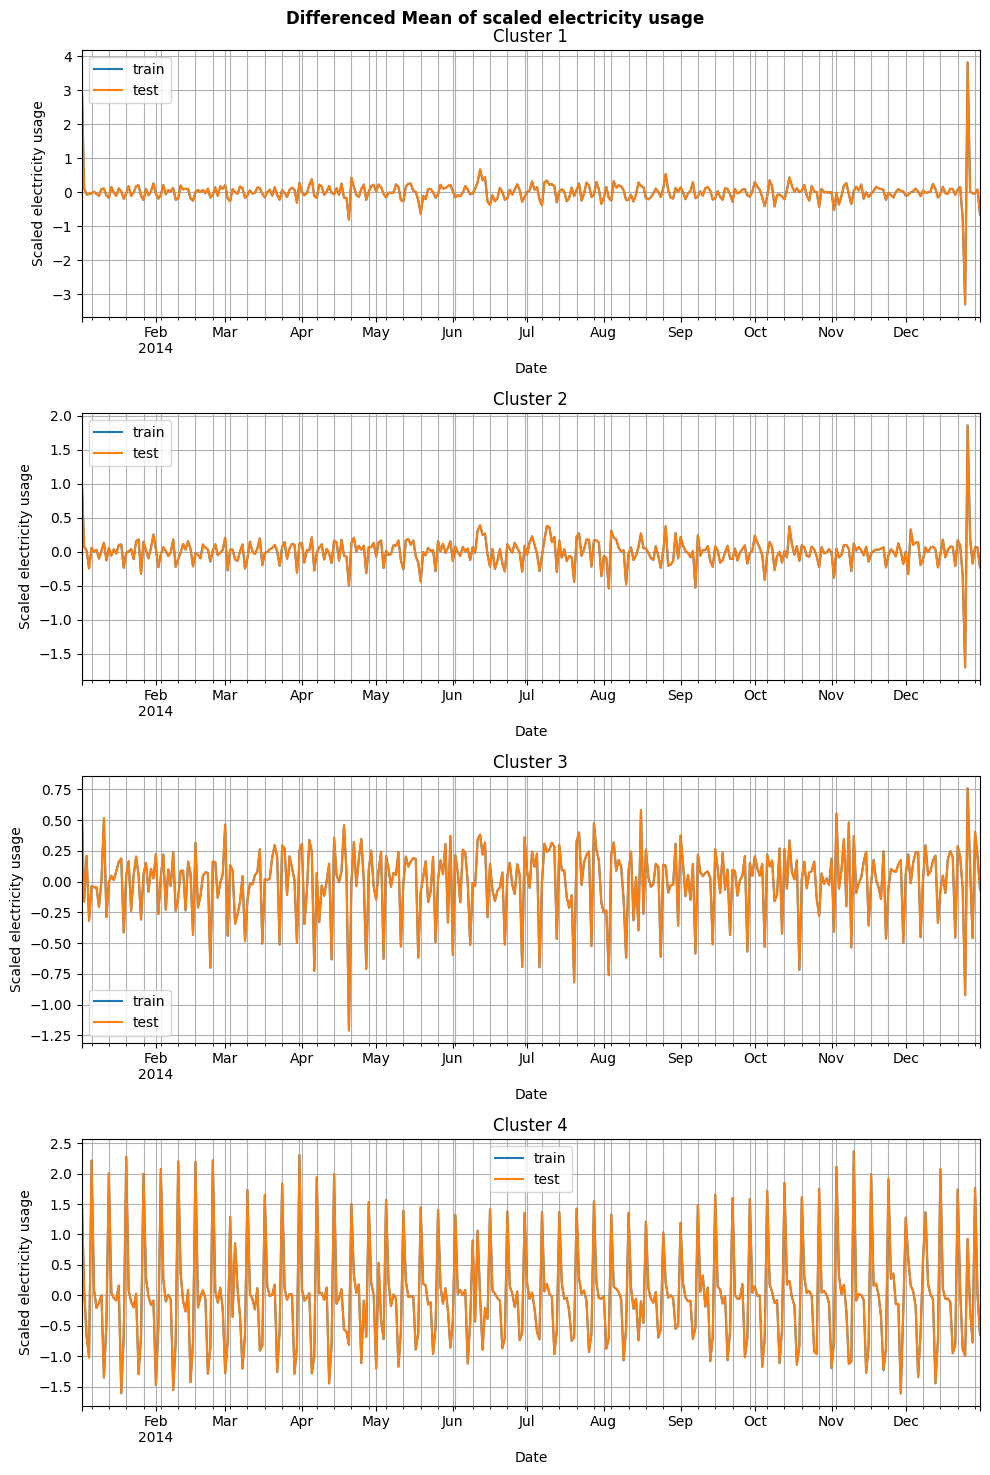

In [110]:
fig, axs = plt.subplots(nrows=len(mean_of_scaled_cluster_dfs), ncols=1, figsize=(10,15))

fig.suptitle('Differenced Mean of scaled electricity usage', fontweight='bold')

for i, (ax, train_df, test_df) in enumerate(zip(axs, mean_test_series, mean_test_series), start=1):
    train_df.diff().dropna().plot(ax=ax, color='tab:blue', label='train')
    test_df.diff().dropna().plot(ax=ax, color='tab:orange', label='test')

    ax.set_title(f'Cluster {i}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Scaled electricity usage')
    ax.legend()
    ax.grid(True, which='both')

plt.tight_layout()
plt.show()

In [21]:
def show_acf(data, title='', lags=365, diff=1):
    differenced_data = data.diff(diff).dropna()
    plt.figure(figsize=(10, 5))
    plot_acf(differenced_data, lags=lags, ax=plt.gca())
    plt.title(f'{title} - ACF Plot')
    plt.xlabel('Lag')
    plt.ylabel('ACF')
    plt.show()

    acf_values, confint = acf(differenced_data, nlags=lags, alpha=0.05)
    significant_mask = (confint[:,0] > 0) | (confint[:,1] < 0)
    significant_acf_values = acf_values[significant_mask]
    significant_lags = np.where(significant_mask)[0]
    
    print('Statistically signficant ACF values')
    for sig_lag, sig_acf in zip(significant_lags, significant_acf_values):
        print(f'\t{sig_lag}:\t{sig_acf}')

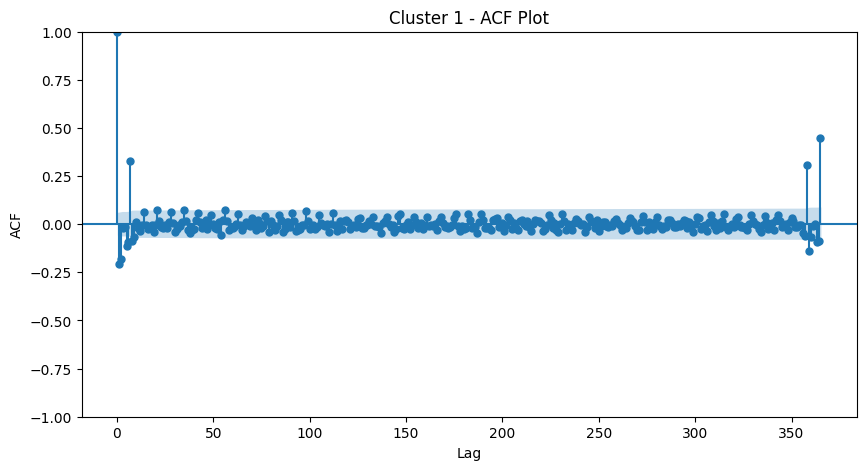

Statistically signficant ACF values
	0:	1.0
	1:	-0.20608940579076493
	2:	-0.18234398054850393
	5:	-0.11182434613266504
	6:	-0.09494074947495572
	7:	0.32641243951171695
	8:	-0.08683425579519964
	21:	0.07559082764486509
	35:	0.07252930246113533
	56:	0.07373707764507136
	358:	0.30531664648448303
	359:	-0.14032759575581194
	363:	-0.09280528846156655
	364:	-0.08660621741431991
	365:	0.44803121334644097


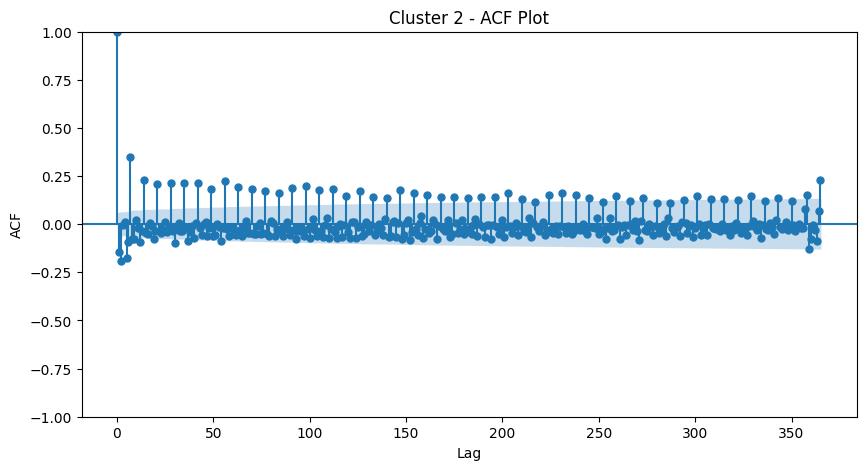

Statistically signficant ACF values
	0:	1.0
	1:	-0.1420704535675342
	2:	-0.19321807839885563
	5:	-0.17365227637109848
	6:	-0.09063808158540916
	7:	0.3466644389701415
	8:	-0.07934935440564703
	9:	-0.07663715059161165
	12:	-0.09165695622612922
	14:	0.22890469656821155
	19:	-0.07833092879996517
	21:	0.2080697359682548
	28:	0.2117245878896587
	30:	-0.09777084944069343
	35:	0.2158820101395864
	37:	-0.08722957654094061
	42:	0.2149565646341431
	49:	0.18496490987665618
	56:	0.22514371338170142
	63:	0.19552985950326005
	70:	0.1818772461710194
	77:	0.17305892202786585
	84:	0.15969291273051664
	91:	0.18696239356052854
	98:	0.19817325581433515
	105:	0.17671219233631
	112:	0.1806900271167332
	119:	0.14782181107862558
	126:	0.17017751318227287
	133:	0.13901526614895743
	140:	0.13765511668961505
	147:	0.17656099625127386
	154:	0.1608334965773583
	161:	0.1514678265772145
	168:	0.14125639343697968
	175:	0.14348111079969775
	182:	0.13779190072122494
	189:	0.14380374838006318
	196:	0.14214545942348228
	2

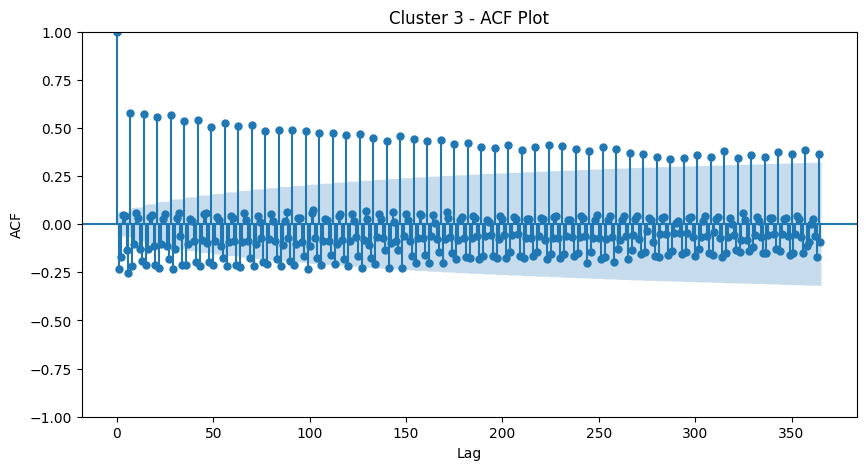

Statistically signficant ACF values
	0:	1.0
	1:	-0.23169560355348998
	2:	-0.17003849447593297
	5:	-0.13403136690530862
	6:	-0.25206430890790066
	7:	0.5774589095921405
	8:	-0.21880944107435735
	9:	-0.10408595879127483
	12:	-0.12895306935625606
	13:	-0.18890416021736087
	14:	0.571683729108922
	15:	-0.21389011362240343
	16:	-0.12723916928105694
	19:	-0.11398598726623352
	20:	-0.21249339524784058
	21:	0.557218583372087
	22:	-0.22540257137096323
	27:	-0.18050391779166947
	28:	0.5668244254636742
	29:	-0.2312401810589486
	34:	-0.2125123452971226
	35:	0.5349718458943932
	36:	-0.21101131994707517
	41:	-0.19566260934578567
	42:	0.5436762240578116
	43:	-0.21565850557743593
	48:	-0.1965614179626763
	49:	0.5039334339923285
	50:	-0.21151813338003594
	55:	-0.17408462708063377
	56:	0.5277620407191953
	57:	-0.2152659802211672
	62:	-0.2127885329870379
	63:	0.5085278990361611
	64:	-0.22227332207214945
	69:	-0.1744178100742329
	70:	0.5172987451933612
	71:	-0.21627058919299771
	76:	-0.19745614367146228
	77

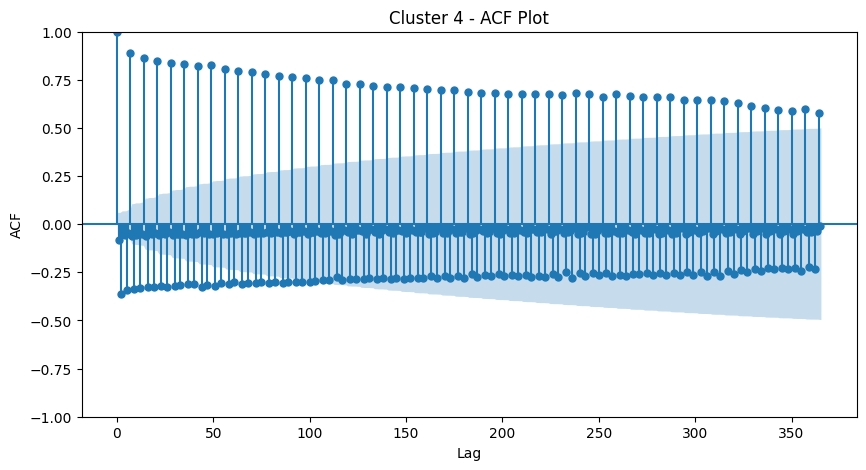

Statistically signficant ACF values
	0:	1.0
	1:	-0.08447851258083786
	2:	-0.3600919431310903
	5:	-0.3439445409457191
	7:	0.8890342612967781
	9:	-0.33531465273683436
	12:	-0.32943815784024016
	14:	0.8657404771703646
	16:	-0.3267365823646128
	19:	-0.325700282252491
	21:	0.8470100497197459
	23:	-0.3217979143511875
	26:	-0.3243902355167915
	28:	0.8367125056688196
	30:	-0.3188106895319754
	33:	-0.31319070278138594
	35:	0.8326695688374958
	37:	-0.3105283981722091
	40:	-0.3106338098896734
	42:	0.8211909783709176
	44:	-0.32464907367406076
	47:	-0.3174122059899601
	49:	0.8275168482716928
	51:	-0.32322839887168037
	54:	-0.3058052161480897
	56:	0.8038279776955182
	58:	-0.31155716407523537
	61:	-0.3014654950997924
	63:	0.7940635092659561
	65:	-0.3093962732307255
	68:	-0.3057032878183201
	70:	0.7909440686098969
	72:	-0.3066504696071862
	75:	-0.3014239529149919
	77:	0.7794493919172883
	79:	-0.3055041550274037
	82:	-0.30129578842456733
	84:	0.7720405069692619
	86:	-0.30313561215936585
	89:	-0.2983172

In [22]:
for i, df in enumerate(mean_series, start=1):
    show_acf(df, title=f'Cluster {i}')

In [23]:
def show_pacf(data, title='', lags=365, diff=1):
    differenced_data = data.diff(diff).dropna()
    plt.figure(figsize=(10, 5))
    plot_pacf(differenced_data, lags=lags)
    plt.title(f'{title} - PACF Plot')
    plt.xlabel('Lag')
    plt.ylabel('PACF')
    plt.show()

    pacf_values, confint = pacf(differenced_data, nlags=lags, alpha=0.05)
    significant_mask = (confint[:,0] > 0) | (confint[:,1] < 0)
    significant_pacf_values = pacf_values[significant_mask]
    significant_lags = np.where(significant_mask)[0]

    print('Statistically signficant PACF values')
    for sig_lag, sig_pacf in zip(significant_lags, significant_pacf_values):
        print(f'\t{sig_lag}:\t{sig_pacf}')

<Figure size 1000x500 with 0 Axes>

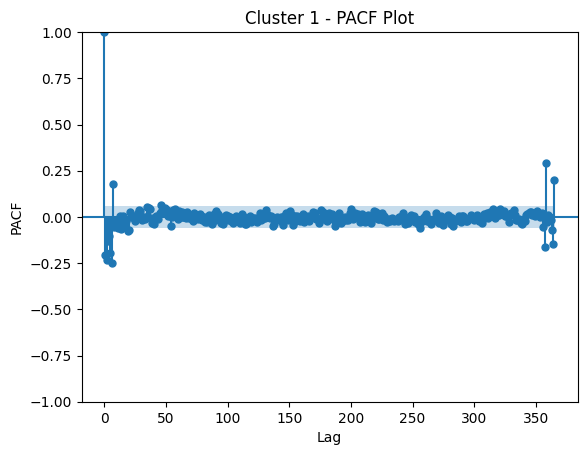

Statistically signficant PACF values
	0:	1.0
	1:	-0.2062779596844435
	2:	-0.23523806035780287
	3:	-0.12942428663135752
	4:	-0.1061015591824201
	5:	-0.1974560842559656
	6:	-0.249897215432769
	7:	0.1776164037687959
	14:	-0.0660682336616594
	19:	-0.07783435988443448
	20:	-0.07389084750562805
	46:	0.06834913304187899
	256:	-0.08598859029605191
	265:	-0.06103458800238945
	275:	-0.06864994004645009
	281:	-0.06760006779652322
	283:	-0.08724386220950435
	289:	-0.06963492092021285
	293:	-0.06775807089217772
	294:	-0.07403443642497441
	295:	-0.06379591032175444
	299:	-0.07697356098506729
	300:	-0.08575909309429905
	301:	-0.07284928380618552
	303:	-0.06850366935421051
	304:	-0.11374778211228069
	305:	-0.11250813023337862
	306:	-0.16207230934824154
	307:	-0.15286199157034325
	308:	-0.13881601991375517
	309:	-0.1601343428078738
	310:	-0.1779546369935711
	311:	-0.25761769738763435
	312:	-0.29264374080197736
	313:	-0.40968820894101604
	314:	-0.6893824796105725
	315:	-2.1036221385137814
	316:	1.948751

<Figure size 1000x500 with 0 Axes>

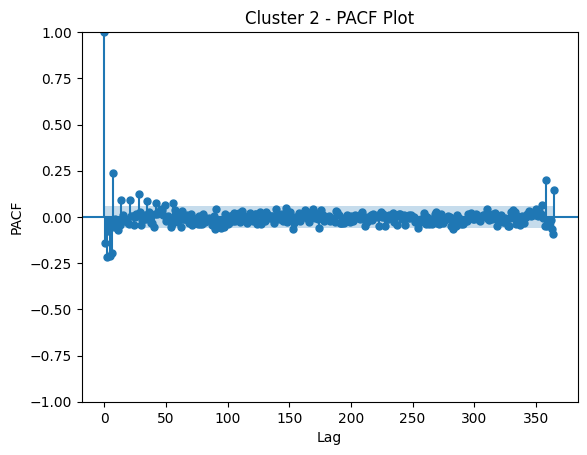

Statistically signficant PACF values
	0:	1.0
	1:	-0.14220043568424737
	2:	-0.21820524189314217
	3:	-0.07452185360939317
	5:	-0.21210100217484365
	6:	-0.19402250399142665
	7:	0.238820533058411
	11:	-0.07183995239322022
	14:	0.09460850358557729
	21:	0.0952555682355601
	28:	0.13040622864527976
	35:	0.09264686488273666
	42:	0.08203322727077339
	49:	0.07126938733848642
	56:	0.08136600588188633
	62:	-0.06038216183391201
	90:	-0.07445274874061836
	95:	-0.06934076150562597
	97:	-0.06269157255875847
	147:	0.059811861680967755
	153:	-0.07814616488183991
	174:	-0.07313441813255475
	211:	-0.06274860070106023
	223:	-0.0626255823332354
	228:	-0.06386849342104518
	237:	-0.06255495193309367
	244:	-0.06298239147614382
	254:	-0.08119700993292123
	271:	-0.06255912199553748
	281:	-0.07182361891213145
	283:	-0.10226579437155647
	285:	-0.08125203687095477
	289:	-0.06642601042501008
	290:	-0.06681603370644836
	291:	-0.07710229477532289
	292:	-0.06555607865715753
	305:	-0.06017998377234776
	312:	-0.0598944684

<Figure size 1000x500 with 0 Axes>

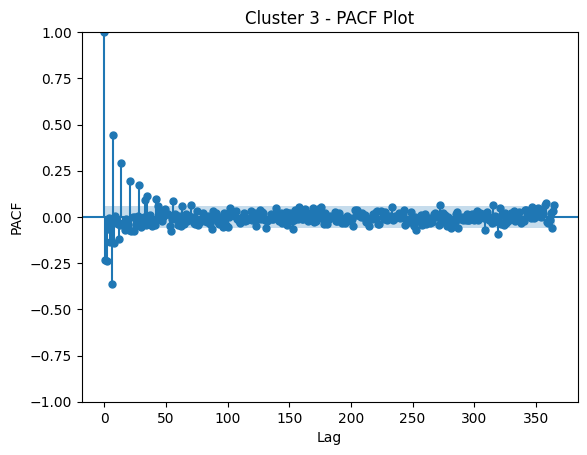

Statistically signficant PACF values
	0:	1.0
	1:	-0.23190758489251415
	2:	-0.236870194451427
	3:	-0.06488574404837891
	5:	-0.13806432830545884
	6:	-0.3652057165482704
	7:	0.44799165007924885
	8:	-0.1421497703942635
	12:	-0.11928367194390023
	14:	0.29721504262627696
	17:	-0.0743682337761563
	20:	-0.07418607492200556
	21:	0.20486052142760056
	22:	-0.08338276704702409
	24:	-0.07689819267022137
	28:	0.18473027903814226
	33:	0.09692801587104856
	35:	0.12470476210672644
	42:	0.10961891880131146
	44:	0.06562429225588272
	54:	-0.08068879016571301
	56:	0.10165141323096595
	63:	0.07591853703992474
	70:	0.08419850880145685
	87:	-0.06555772545231787
	96:	-0.06146229961187619
	100:	-0.06232940113461896
	131:	-0.07191977174426427
	148:	-0.05997005344906274
	153:	-0.07491411455559999
	158:	0.06501897846325033
	175:	0.059555316547851816
	176:	0.06913868255063474
	202:	-0.08134589173015812
	215:	-0.06349340881197968
	223:	-0.06329631537108589
	233:	0.07029294598208044
	244:	-0.08563313286088527
	251:	-

<Figure size 1000x500 with 0 Axes>

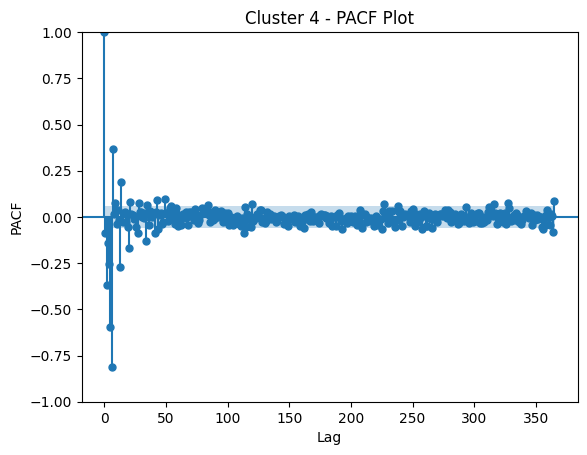

Statistically signficant PACF values
	0:	1.0
	1:	-0.08455580307725219
	2:	-0.37055045461352915
	3:	-0.14308021539698923
	4:	-0.25716530189451686
	5:	-0.5999358062939489
	6:	-0.8256824996263679
	7:	0.3495520486218256
	9:	0.08059134091021909
	13:	-0.29168565400130875
	14:	0.1922522896743124
	19:	-0.06435246316978806
	20:	-0.19464649284269356
	21:	0.08665410476597084
	26:	-0.0682523515719185
	27:	-0.11376397109505375
	28:	0.08213969284755152
	34:	-0.16044600599197906
	35:	0.07612303490780875
	41:	-0.12221908353254794
	43:	0.107614013505732
	44:	-0.06515120920999261
	49:	0.12438438123923849
	53:	0.06042882717076825
	54:	0.06416443236929004
	62:	-0.06677950264721533
	84:	0.08172141363464476
	104:	-0.06621122691533221
	111:	-0.07638373628370553
	113:	-0.1095014682289307
	114:	0.068624204115515
	119:	-0.06756777528812744
	120:	0.07047000640335326
	146:	-0.06006914211923994
	149:	-0.0641023980256458
	159:	-0.0788577132488482
	162:	-0.07520376087513511
	174:	-0.06557050321269026
	188:	-0.096971

In [24]:
for i, df in enumerate(mean_series, start=1):
    show_pacf(df, title=f'Cluster {i}')

In [30]:
def test_sarima(training_time_series, test_time_series, order, seasonal_order, exog_train=None, exog_test=None, max_iter=100):
    model = SARIMAX(pd.Series(training_time_series), 
                    exog=exog_train,
                    order=order,  # AR(p), differencing (d=1), MA(q)
                    seasonal_order=seasonal_order,  # Seasonal AR(P), Seasonal differencing (D=1), Seasonal MA(Q), S=365 for yearly seasonality
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    
    results = model.fit(disp=False, lowmemory=True, maxiter=max_iter)

    print(results.summary())
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
    
    predicted_test_time_series = results.forecast(steps=len(test_time_series), exog=exog_test).sort_index()
    test_time_series = test_time_series.sort_index()
    
    predicted_test_time_series.plot(ax=ax, label='Predicted')
    test_time_series.plot(ax=ax, label='Actual')
    
    ax.legend()
    ax.set_title('Mean of scaled electricity usage')
    ax.set_xlabel('Date')
    ax.set_ylabel('')
    ax.grid(True, which='both')
    
    plt.tight_layout()
    plt.show()

    mse = mean_squared_error(predicted_test_time_series, test_time_series)
    r2 = r2_score(predicted_test_time_series, test_time_series)
    mape = mean_absolute_percentage_error(predicted_test_time_series, test_time_series)
    print(f"\nMean Squared Error (MSE): {mse}")
    print(f"R-squared: {r2 * 100:.2f}%")
    print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")

### Cluster 1

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  730
Model:             SARIMAX(2, 1, 1)x(0, 1, [], 365)   Log Likelihood                 -20.531
Date:                              Mon, 17 Mar 2025   AIC                             49.061
Time:                                      20:24:51   BIC                             64.628
Sample:                                  01-02-2012   HQIC                            55.250
                                       - 12-31-2013                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1776      0.211      0.840      0.401      -0.237       0.592
ar.L2         -0.22

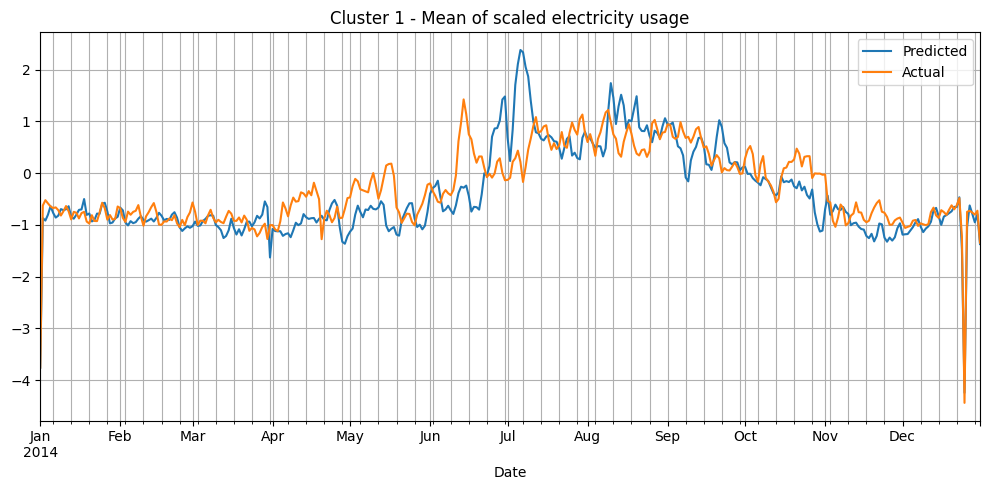


Mean Squared Error (MSE): 0.25575127184993224
R-squared: 63.52%
Mean Absolute Percentage Error (MAPE): 82.01%


In [118]:
i = 0
test_sarima(
    training_time_series=mean_of_scaled_cluster_dfs_train[i],
    test_time_series=mean_of_scaled_cluster_dfs_test[i],
    order=(2, 1, 1),
    seasonal_order=(0, 1, 0, 365),
)

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  730
Model:             SARIMAX(2, 1, 0)x(0, 1, 0, 365)   Log Likelihood                 -20.587
Date:                             Mon, 17 Mar 2025   AIC                             47.175
Time:                                     20:25:28   BIC                             58.850
Sample:                                 01-02-2012   HQIC                            51.816
                                      - 12-31-2013                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0891      0.037      2.405      0.016       0.016       0.162
ar.L2         -0.2190      

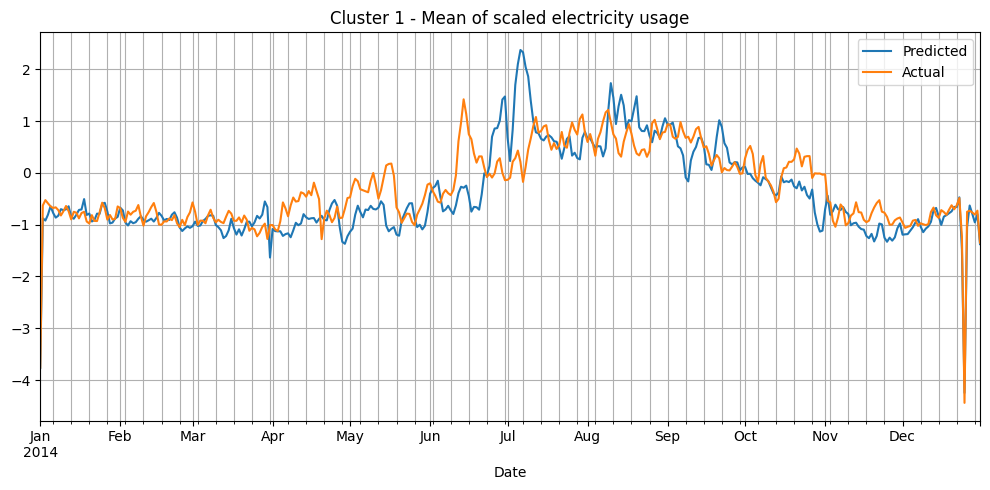


Mean Squared Error (MSE): 0.25617726893084164
R-squared: 63.46%
Mean Absolute Percentage Error (MAPE): 78.38%


In [119]:
i = 0
test_sarima(
    training_time_series=mean_of_scaled_cluster_dfs_train[i],
    test_time_series=mean_of_scaled_cluster_dfs_test[i],
    order=(2, 1, 0),
    seasonal_order=(0, 1, 0, 365),
)

/Users/luiz/Documents/Projects/ieor_4578_project1/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  730
Model:               SARIMAX(7, 1, 8)   Log Likelihood                  -3.116
Date:                Tue, 18 Mar 2025   AIC                             52.231
Time:                        19:59:02   BIC                            157.554
Sample:                    01-02-2012   HQIC                            92.892
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
heating_degree_days      -0.0654      0.009     -6.948      0.000      -0.084      -0.047
cooling_degree_days       0.1550      0.011     14.550      0.000       0.134       0.176
precip  

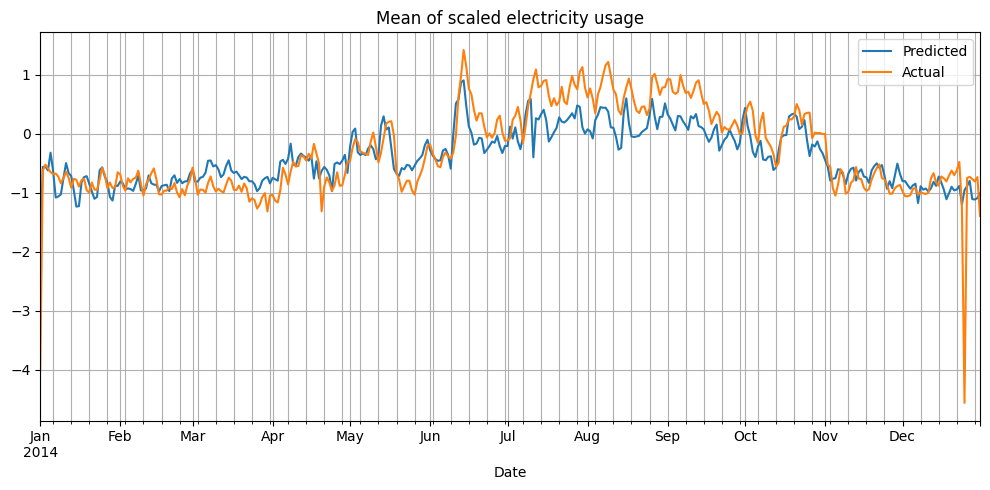


Mean Squared Error (MSE): 0.16968009484716173
R-squared: 20.47%
Mean Absolute Percentage Error (MAPE): 277.18%


In [27]:
i = 0
test_sarima(
    training_time_series=mean_train_series[i].sort_index(),
    test_time_series=mean_test_series[i].sort_index(),
    exog_train=explanatory_variables_df[explanatory_variables_df.index < pd.to_datetime('2014-01-01')].sort_index()[1:],
    exog_test=explanatory_variables_df[explanatory_variables_df.index >= pd.to_datetime('2014-01-01')].sort_index()[1:],
    order=(7, 1, 8),
    seasonal_order=(0, 0, 0, 0),
)

/Users/luiz/Documents/Projects/ieor_4578_project1/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  730
Model:             SARIMAX(7, 1, 8)x(0, 1, [], 365)   Log Likelihood                 135.295
Date:                              Tue, 18 Mar 2025   AIC                           -224.589
Time:                                      20:08:33   BIC                           -135.531
Sample:                                  01-02-2012   HQIC                          -189.159
                                       - 12-31-2013                                         
Covariance Type:                                opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
heating_degree_days      -0.0522      0.007     -7.436      0.000      -0.06

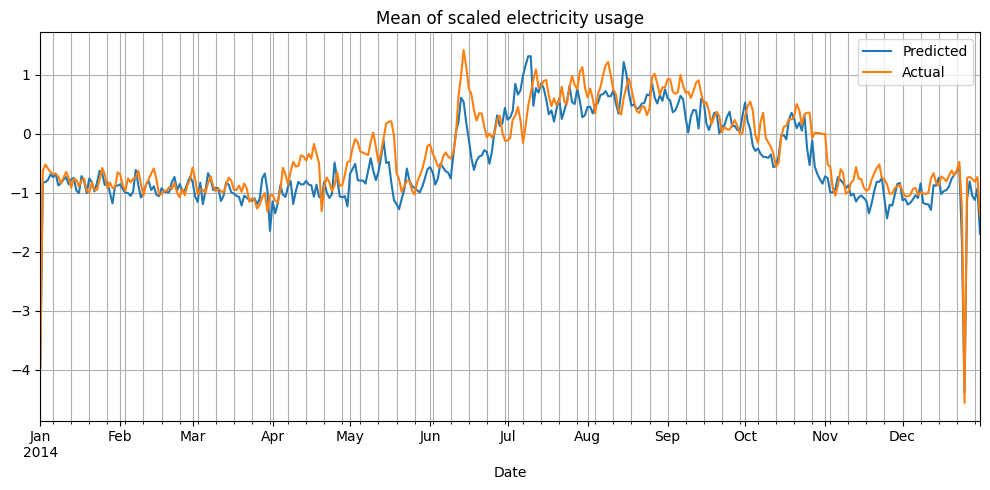


Mean Squared Error (MSE): 0.12040880831754218
R-squared: 76.85%
Mean Absolute Percentage Error (MAPE): 78.73%


In [31]:
i = 0
test_sarima(
    training_time_series=mean_train_series[i].sort_index(),
    test_time_series=mean_test_series[i].sort_index(),
    exog_train=explanatory_variables_df[explanatory_variables_df.index < pd.to_datetime('2014-01-01')].sort_index()[1:],
    exog_test=explanatory_variables_df[explanatory_variables_df.index >= pd.to_datetime('2014-01-01')].sort_index()[1:],
    order=(7, 1, 8),
    seasonal_order=(0, 1, 0, 365),
    max_iter=1
)

/Users/luiz/Documents/Projects/ieor_4578_project1/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  730
Model:             SARIMAX(7, 1, 7)x(0, 1, [], 365)   Log Likelihood                 134.245
Date:                              Tue, 18 Mar 2025   AIC                           -224.489
Time:                                      21:10:30   BIC                           -139.241
Sample:                                  01-02-2012   HQIC                          -190.579
                                       - 12-31-2013                                         
Covariance Type:                                opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
heating_degree_days      -0.0523      0.007     -7.418      0.000      -0.06

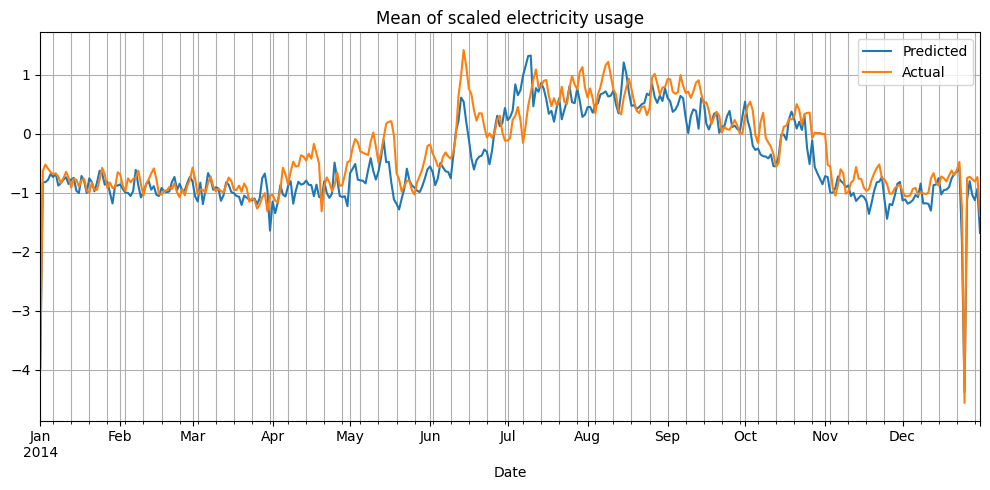


Mean Squared Error (MSE): 0.1194662305424424
R-squared: 77.02%
Mean Absolute Percentage Error (MAPE): 77.40%


In [36]:
i = 0
test_sarima(
    training_time_series=mean_train_series[i].sort_index(),
    test_time_series=mean_test_series[i].sort_index(),
    exog_train=explanatory_variables_df[explanatory_variables_df.index < pd.to_datetime('2014-01-01')].sort_index()[1:],
    exog_test=explanatory_variables_df[explanatory_variables_df.index >= pd.to_datetime('2014-01-01')].sort_index()[1:],
    order=(7, 1, 7),
    seasonal_order=(0, 1, 0, 365),
    max_iter=1
)

### Cluster 2

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  730
Model:             SARIMAX(2, 1, 0)x(0, 1, 0, 365)   Log Likelihood                  23.096
Date:                             Mon, 17 Mar 2025   AIC                            -40.192
Time:                                     20:33:58   BIC                            -28.517
Sample:                                 01-02-2012   HQIC                           -35.551
                                      - 12-31-2013                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0995      0.047     -2.105      0.035      -0.192      -0.007
ar.L2         -0.1903      

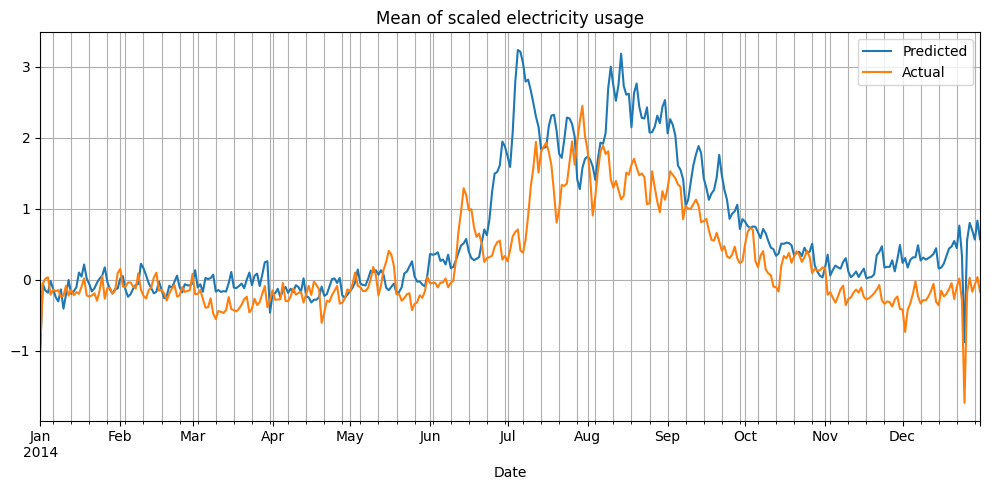


Mean Squared Error (MSE): 0.38914405299565213
R-squared: 52.47%
Mean Absolute Percentage Error (MAPE): 239.69%


In [124]:
i = 1
test_sarima(
    training_time_series=mean_of_scaled_cluster_dfs_train[i],
    test_time_series=mean_of_scaled_cluster_dfs_test[i],
    order=(2, 1, 0),
    seasonal_order=(0, 1, 0, 365),
)

/Users/luiz/Documents/Projects/ieor_4578_project1/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/luiz/Documents/Projects/ieor_4578_project1/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  730
Model:             SARIMAX(2, 1, 0)x(0, 1, 0, 365)   Log Likelihood                  80.091
Date:                             Mon, 17 Mar 2025   AIC                           -140.182
Time:                                     20:59:43   BIC                           -101.266
Sample:                                 01-02-2012   HQIC                          -124.711
                                      - 12-31-2013                                         
Covariance Type:                               opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
heating_degree_days      -0.0157      0.008     -1.921      0.055      -0.032       

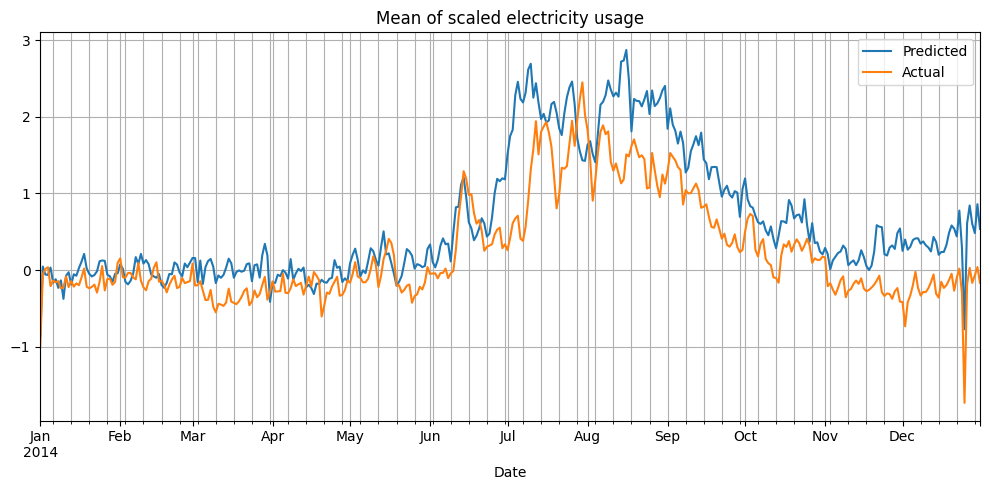


Mean Squared Error (MSE): 0.30439243280612815
R-squared: 55.19%
Mean Absolute Percentage Error (MAPE): 372.63%


In [145]:
i = 1
test_sarima(
    training_time_series=mean_of_scaled_cluster_dfs_train[i].sort_index(),
    test_time_series=mean_of_scaled_cluster_dfs_test[i].sort_index(),
    exog_train=explanatory_variables_df[explanatory_variables_df.index < pd.to_datetime('2014-01-01')].sort_index()[1:],
    exog_test=explanatory_variables_df[explanatory_variables_df.index >= pd.to_datetime('2014-01-01')].sort_index()[1:],
    order=(2, 1, 0),
    seasonal_order=(0, 1, 0, 365),
)

### Cluster 3

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  730
Model:             SARIMAX(2, 1, 0)x(0, 1, 0, 365)   Log Likelihood                -133.445
Date:                             Mon, 17 Mar 2025   AIC                            272.891
Time:                                     20:29:37   BIC                            284.566
Sample:                                 01-02-2012   HQIC                           277.532
                                      - 12-31-2013                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4656      0.050     -9.319      0.000      -0.564      -0.368
ar.L2         -0.2142      

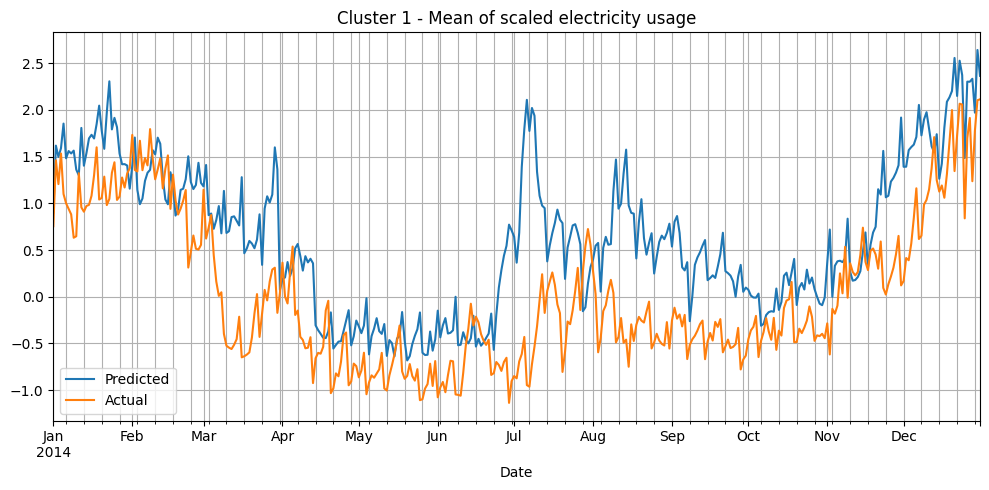


Mean Squared Error (MSE): 0.657365185339376
R-squared: -6.27%
Mean Absolute Percentage Error (MAPE): 2570.65%


In [121]:
i = 2
test_sarima(
    training_time_series=mean_of_scaled_cluster_dfs_train[i],
    test_time_series=mean_of_scaled_cluster_dfs_test[i],
    order=(2, 1, 0),
    seasonal_order=(0, 1, 0, 365),
)

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  730
Model:             SARIMAX(2, 1, 1)x(0, 1, [], 365)   Log Likelihood                -133.364
Date:                              Mon, 17 Mar 2025   AIC                            274.727
Time:                                      20:31:21   BIC                            290.294
Sample:                                  01-02-2012   HQIC                           280.915
                                       - 12-31-2013                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3999      0.292     -1.369      0.171      -0.972       0.173
ar.L2         -0.18

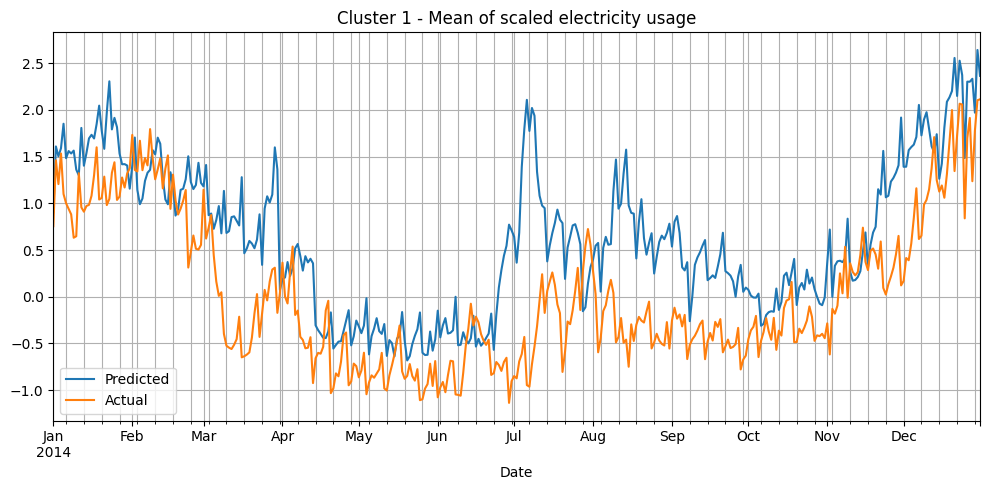


Mean Squared Error (MSE): 0.6572687375305312
R-squared: -6.26%
Mean Absolute Percentage Error (MAPE): 1950.90%


In [122]:
i = 2
test_sarima(
    training_time_series=mean_of_scaled_cluster_dfs_train[i],
    test_time_series=mean_of_scaled_cluster_dfs_test[i],
    order=(2, 1, 1),
    seasonal_order=(0, 1, 0, 365),
)

/Users/luiz/Documents/Projects/ieor_4578_project1/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/luiz/Documents/Projects/ieor_4578_project1/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  730
Model:             SARIMAX(2, 1, 0)x(0, 1, 0, 365)   Log Likelihood                -108.857
Date:                             Mon, 17 Mar 2025   AIC                            237.713
Time:                                     21:05:22   BIC                            276.629
Sample:                                 01-02-2012   HQIC                           253.184
                                      - 12-31-2013                                         
Covariance Type:                               opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
heating_degree_days       0.0325      0.010      3.169      0.002       0.012       

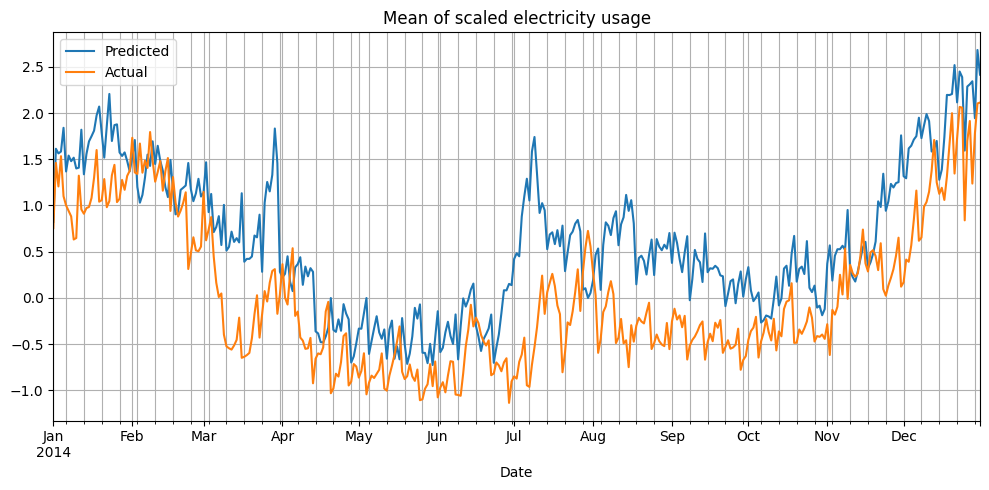


Mean Squared Error (MSE): 0.5565565626980977
R-squared: 6.42%
Mean Absolute Percentage Error (MAPE): 1062.31%


In [146]:
i = 2
test_sarima(
    training_time_series=mean_of_scaled_cluster_dfs_train[i].sort_index(),
    test_time_series=mean_of_scaled_cluster_dfs_test[i].sort_index(),
    exog_train=explanatory_variables_df[explanatory_variables_df.index < pd.to_datetime('2014-01-01')].sort_index()[1:],
    exog_test=explanatory_variables_df[explanatory_variables_df.index >= pd.to_datetime('2014-01-01')].sort_index()[1:],
    order=(2, 1, 0),
    seasonal_order=(0, 1, 0, 365),
)

### Cluster 4

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  730
Model:             SARIMAX(2, 1, 0)x(0, 1, 0, 365)   Log Likelihood                -523.674
Date:                             Mon, 17 Mar 2025   AIC                           1053.348
Time:                                     20:35:05   BIC                           1065.023
Sample:                                 01-02-2012   HQIC                          1057.990
                                      - 12-31-2013                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4530      0.089     -5.096      0.000      -0.627      -0.279
ar.L2         -0.4697      

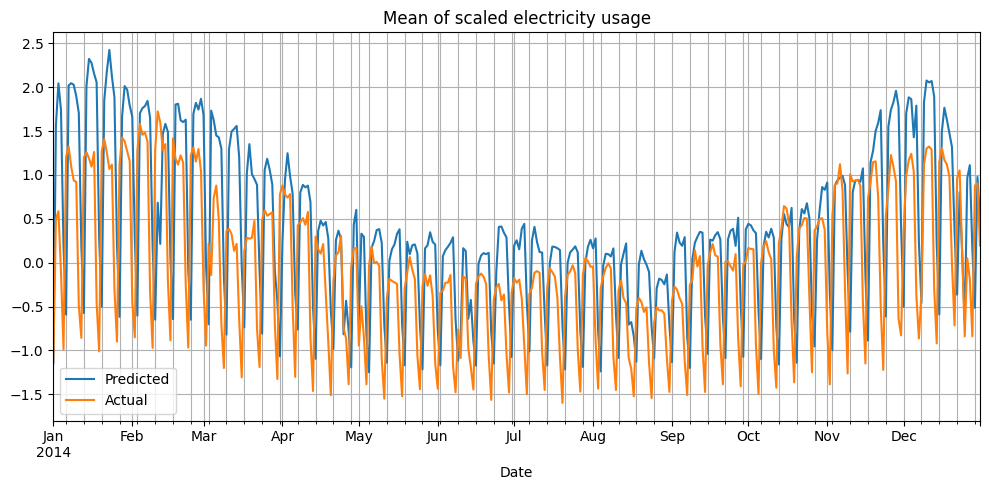


Mean Squared Error (MSE): 0.8554069230120811
R-squared: -1.39%
Mean Absolute Percentage Error (MAPE): 228.21%


In [125]:
i = 3
test_sarima(
    training_time_series=mean_of_scaled_cluster_dfs_train[i],
    test_time_series=mean_of_scaled_cluster_dfs_test[i],
    order=(2, 1, 0),
    seasonal_order=(0, 1, 0, 365),
)

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  730
Model:             SARIMAX(2, 1, 0)x(1, 1, 0, 7)   Log Likelihood                -258.338
Date:                           Mon, 17 Mar 2025   AIC                            524.675
Time:                                   20:39:51   BIC                            542.953
Sample:                               01-02-2012   HQIC                           531.735
                                    - 12-31-2013                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2307      0.020    -11.657      0.000      -0.270      -0.192
ar.L2         -0.3123      0.022    -13.970

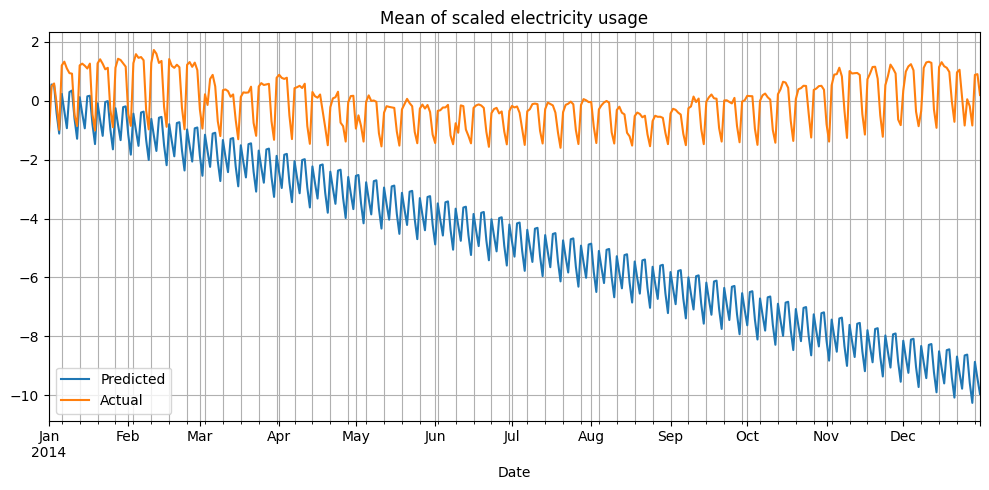


Mean Squared Error (MSE): 29.453488602865725
R-squared: -285.67%
Mean Absolute Percentage Error (MAPE): 157.74%


In [126]:
i = 3
test_sarima(
    training_time_series=mean_of_scaled_cluster_dfs_train[i],
    test_time_series=mean_of_scaled_cluster_dfs_test[i],
    order=(2, 1, 0),
    seasonal_order=(1, 1, 0, 7),
)

/Users/luiz/Documents/Projects/ieor_4578_project1/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/luiz/Documents/Projects/ieor_4578_project1/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  730
Model:             SARIMAX(2, 1, 0)x(0, 1, 0, 365)   Log Likelihood                -286.340
Date:                             Mon, 17 Mar 2025   AIC                            592.680
Time:                                     21:09:38   BIC                            631.596
Sample:                                 01-02-2012   HQIC                           608.151
                                      - 12-31-2013                                         
Covariance Type:                               opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
heating_degree_days       0.0364      0.016      2.237      0.025       0.005       

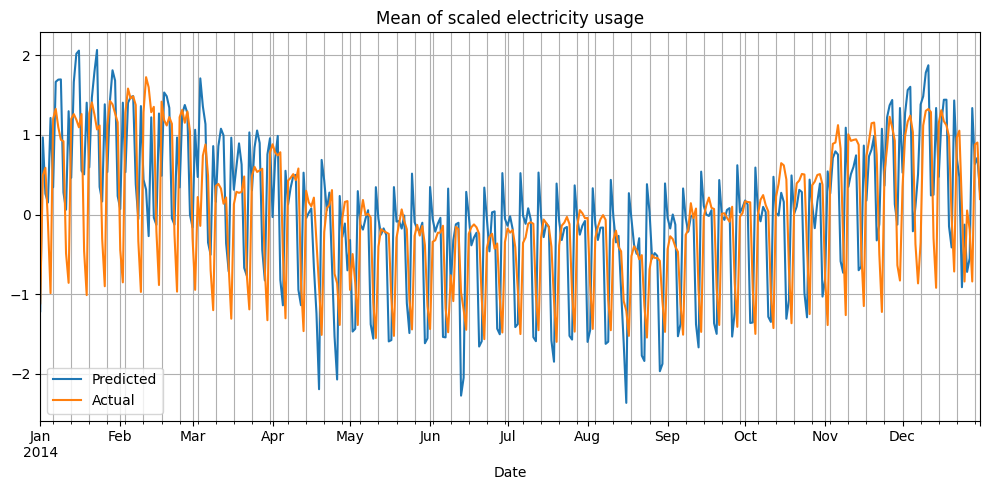


Mean Squared Error (MSE): 0.9381370417404369
R-squared: -10.80%
Mean Absolute Percentage Error (MAPE): 628.88%


In [147]:
i = 3
test_sarima(
    training_time_series=mean_of_scaled_cluster_dfs_train[i].sort_index(),
    test_time_series=mean_of_scaled_cluster_dfs_test[i].sort_index(),
    exog_train=explanatory_variables_df[explanatory_variables_df.index < pd.to_datetime('2014-01-01')].sort_index()[1:],
    exog_test=explanatory_variables_df[explanatory_variables_df.index >= pd.to_datetime('2014-01-01')].sort_index()[1:],
    order=(2, 1, 0),
    seasonal_order=(0, 1, 0, 365),
)

In [ ]:
i = 3
test_sarima(
    training_time_series=mean_train_series[i].sort_index(),
    test_time_series=mean_test_series[i].sort_index(),
    exog_train=explanatory_variables_df[explanatory_variables_df.index < pd.to_datetime('2014-01-01')].sort_index()[1:],
    exog_test=explanatory_variables_df[explanatory_variables_df.index >= pd.to_datetime('2014-01-01')].sort_index()[1:],
    order=(4, 1, 2),
    seasonal_order=(0, 1, 0, 365),
)

/Users/luiz/Documents/Projects/ieor_4578_project1/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Train models on the mean

### Cluster 1

In [39]:
LOAD = True
MODEL_SAVE_PATH = 'models/sarimax/cluster1/model.pickle'

i = 0
mean_train = mean_train_series[i]
mean_test = mean_test_series[i]
selected_explanatory_variables_df = explanatory_variables_df.drop(columns=[
    'precipprob', 
    'sunlight_length_hours'
])

exog_train = selected_explanatory_variables_df.loc[mean_train.index].asfreq('D')
exog_test = selected_explanatory_variables_df.loc[mean_test.index].asfreq('D')

if LOAD:
    print(f'Loading model from {MODEL_SAVE_PATH}')
    cluster_1_fit_model = SARIMAXResults.load(MODEL_SAVE_PATH)
    print('Done')
else:
    print('Training model...')
    order = (5, 1, 0)
    seasonal_order = (0, 1, 0, 365)
    
    cluster_1_model = SARIMAX(mean_train, 
                              exog=exog_train,
                              order=order,  # AR(p), differencing (d=1), MA(q)
                              seasonal_order=seasonal_order,  # Seasonal AR(P), Seasonal differencing (D=1), Seasonal MA(Q), S=365 for yearly seasonality
                              enforce_stationarity=False,
                              enforce_invertibility=False)
    
    cluster_1_fit_model = cluster_1_model.fit(disp=True, lowmemory=True, maxiter=10)

    print(f'Saving model to {MODEL_SAVE_PATH}')
    cluster_1_fit_model.save(MODEL_SAVE_PATH)
    print('Done')

print(cluster_1_fit_model.summary())

Training model...


/Users/luiz/Documents/Projects/ieor_4578_project1/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Saving model to models/sarimax/cluster1/model.pickle
Done
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  730
Model:             SARIMAX(5, 1, 0)x(0, 1, 0, 365)   Log Likelihood                 123.986
Date:                             Tue, 18 Mar 2025   AIC                           -225.973
Time:                                     21:25:00   BIC                           -183.256
Sample:                                 01-02-2012   HQIC                          -208.986
                                      - 12-31-2013                                         
Covariance Type:                               opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
heating_degree_days    -0.0603

### Cluster 2

In [41]:
LOAD = True
MODEL_SAVE_PATH = 'models/sarimax/cluster2/model.pickle'

i = 1
mean_train = mean_train_series[i]
mean_test = mean_test_series[i]
selected_explanatory_variables_df = explanatory_variables_df.drop(columns=[
    'precipprob', 
    'is_holiday',
    'sunlight_length_hours',
])

exog_train = selected_explanatory_variables_df.loc[mean_train.index].asfreq('D')
exog_test = selected_explanatory_variables_df.loc[mean_test.index].asfreq('D')

if LOAD:
    print(f'Loading model from {MODEL_SAVE_PATH}')
    cluster_2_fit_model = SARIMAXResults.load(MODEL_SAVE_PATH)
    print('Done')
else:
    print('Training model...')
    order = (7, 1, 0)
    seasonal_order = (0, 1, 0, 365)
    
    cluster_2_model = SARIMAX(mean_train, 
                              exog=exog_train,
                              order=order,  # AR(p), differencing (d=1), MA(q)
                              seasonal_order=seasonal_order,  # Seasonal AR(P), Seasonal differencing (D=1), Seasonal MA(Q), S=365 for yearly seasonality
                              enforce_stationarity=False,
                              enforce_invertibility=False)
    
    cluster_2_fit_model = cluster_2_model.fit(disp=True, lowmemory=True, maxiter=10)

    print(f'Saving model to {MODEL_SAVE_PATH}')
    cluster_2_fit_model.save(MODEL_SAVE_PATH)
    print('Done')

print(cluster_2_fit_model.summary())

Training model...


/Users/luiz/Documents/Projects/ieor_4578_project1/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Saving model to models/sarimax/cluster2/model.pickle
Done
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  730
Model:             SARIMAX(7, 1, 0)x(0, 1, 0, 365)   Log Likelihood                 133.620
Date:                             Tue, 18 Mar 2025   AIC                           -243.240
Time:                                     21:36:17   BIC                           -196.708
Sample:                                 01-02-2012   HQIC                          -224.732
                                      - 12-31-2013                                         
Covariance Type:                               opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
heating_degree_days    -0.0101

### Cluster 3

In [43]:
LOAD = True
MODEL_SAVE_PATH = 'models/sarimax/cluster3/model.pickle'

i = 2
mean_train = mean_train_series[i]
mean_test = mean_test_series[i]
selected_explanatory_variables_df = explanatory_variables_df.drop(columns=[
    'precip', 
    'is_holiday',
    'sunlight_length_hours',
    'is_weekend',
])

exog_train = selected_explanatory_variables_df.loc[mean_train.index].asfreq('D')
exog_test = selected_explanatory_variables_df.loc[mean_test.index].asfreq('D')

if LOAD:
    print(f'Loading model from {MODEL_SAVE_PATH}')
    cluster_3_fit_model = SARIMAXResults.load(MODEL_SAVE_PATH)
    print('Done')
else:
    print('Training model...')
    order = (7, 1, 0)
    seasonal_order = (0, 1, 0, 365)
    
    cluster_3_model = SARIMAX(mean_train, 
                              exog=exog_train,
                              order=order,  # AR(p), differencing (d=1), MA(q)
                              seasonal_order=seasonal_order,  # Seasonal AR(P), Seasonal differencing (D=1), Seasonal MA(Q), S=365 for yearly seasonality
                              enforce_stationarity=False,
                              enforce_invertibility=False)
    
    cluster_3_fit_model = cluster_3_model.fit(disp=True, lowmemory=True, maxiter=10)

    print(f'Saving model to {MODEL_SAVE_PATH}')
    cluster_3_fit_model.save(MODEL_SAVE_PATH)
    print('Done')

print(cluster_3_fit_model.summary())

Training model...


/Users/luiz/Documents/Projects/ieor_4578_project1/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Saving model to models/sarimax/cluster3/model.pickle
Done
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  730
Model:             SARIMAX(7, 1, 0)x(0, 1, 0, 365)   Log Likelihood                 -38.105
Date:                             Tue, 18 Mar 2025   AIC                             98.211
Time:                                     21:45:34   BIC                            140.866
Sample:                                 01-02-2012   HQIC                           115.177
                                      - 12-31-2013                                         
Covariance Type:                               opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
heating_degree_days     0.0319

### Cluster 4

In [10]:
LOAD = False
MODEL_SAVE_PATH = 'models/sarimax/cluster4/model.pickle'

i = 3
mean_train = mean_train_series[i]
mean_test = mean_test_series[i]
selected_explanatory_variables_df = explanatory_variables_df.drop(columns=[
    'cooling_degree_days', 
    'precip',
    'precipprob',
    'is_weekend',
    'sunlight_length_hours',
])

exog_train = selected_explanatory_variables_df.loc[mean_train.index].asfreq('D')
exog_test = selected_explanatory_variables_df.loc[mean_test.index].asfreq('D')

if LOAD:
    print(f'Loading model from {MODEL_SAVE_PATH}')
    cluster_4_fit_model = SARIMAXResults.load(MODEL_SAVE_PATH)
    print('Done')
else:
    print('Training model...')
    order = (7, 1, 0)
    seasonal_order = (0, 1, 0, 365)
    
    cluster_4_model = SARIMAX(mean_train, 
                              exog=exog_train,
                              order=order,  # AR(p), differencing (d=1), MA(q)
                              seasonal_order=seasonal_order,  # Seasonal AR(P), Seasonal differencing (D=1), Seasonal MA(Q), S=365 for yearly seasonality
                              enforce_stationarity=False,
                              enforce_invertibility=False)
    
    cluster_4_fit_model = cluster_4_model.fit(disp=True, lowmemory=True, maxiter=10)

    print(f'Saving model to {MODEL_SAVE_PATH}')
    cluster_4_fit_model.save(MODEL_SAVE_PATH)
    print('Done')

print(cluster_4_fit_model.summary())

Training model...


/Users/luiz/Documents/Projects/ieor_4578_project1/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Saving model to models/sarimax/cluster4/model.pickle
Done
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  730
Model:             SARIMAX(7, 1, 0)x(0, 1, 0, 365)   Log Likelihood                -107.220
Date:                             Tue, 18 Mar 2025   AIC                            234.441
Time:                                     22:09:43   BIC                            273.218
Sample:                                 01-02-2012   HQIC                           249.864
                                      - 12-31-2013                                         
Covariance Type:                               opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
heating_degree_days     0.0501